In [1144]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import torch.nn.functional as F

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import shap

In [1145]:
# load dataset
height = 4
width = 4
depth = 24

all_hists = []
labels = []
zero_hists = []

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [1, 0, 0],
#     2: [0, 1, 0],
#     3: [0, 0, 1],
# }

zone_to_label = {
    0: [0, 0, 0],
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1],
    4: [1, 1, 0],
    5: [1, 0, 1],
    6: [0, 1, 1],
    7: [1, 1, 1],
}

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [1, 0, 0],
#     2: [0, 0, 0],
#     3: [0, 0, 0],
#     4: [1, 0, 0],
#     5: [1, 0, 0],
#     6: [0, 0, 0],
# }

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [0, 0, 0],
#     2: [0, 1, 0],
#     3: [0, 0, 0],
#     4: [0, 1, 0],
#     5: [0, 0, 0],
#     6: [0, 1, 0],
# }

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [1, 0, 0],
#     2: [1, 0, 0],
#     3: [1, 0, 0],
#     4: [1, 0, 0],
#     5: [1, 0, 0],
#     6: [1, 0, 0],
# }

In [1146]:
for i in range(4):
    hists = np.load(f'datasets/display-box-11/histograms_{i}.npy')
    all_hists.append(hists)

    if i == 0:
        zero_hists.append(hists)
    
    # labels += [i] * len(hists)

    # is_nonzero = (i != 0)
    # labels += [is_nonzero] * len(hists)

    labels += [zone_to_label[i]] * len(hists)

In [1147]:
zero_hists = np.concatenate(zero_hists, axis=0)
all_hists = np.concatenate(all_hists, axis=0)
labels = np.array(labels)

all_hists = all_hists.reshape(-1, height, width, depth)
# move depth to the front
all_hists = np.moveaxis(all_hists, -1, 1)

zero_hists = zero_hists.reshape(-1, height, width, depth)
zero_hists = np.moveaxis(zero_hists, -1, 1)

# crop first bounce bins (first bounce in first 2 bins)
all_hists = all_hists[:, 2:, :, :]
zero_hists = zero_hists[:, 2:, :, :]


# generate more data by adding gaussian noise

# all_hists = np.repeat(all_hists, 10, axis=0)
# labels = np.repeat(labels, 10, axis=0)

# add noise
# std = 3 is good for general training?
# all_hists += np.random.normal(0, 1, all_hists.shape)



all_hists = torch.tensor(all_hists, dtype=torch.float32)
zero_hists = torch.tensor(zero_hists, dtype=torch.float32)


In [1148]:
labels_mask = np.all(labels == np.array([0, 0, 0]), axis=1)

In [1149]:
(labels_mask == 1).sum()

1000

In [1150]:
all_hists_zero_label = all_hists[labels_mask]

In [1151]:
all_hists_zero_label[:, 0, :, :].shape

torch.Size([1000, 4, 4])

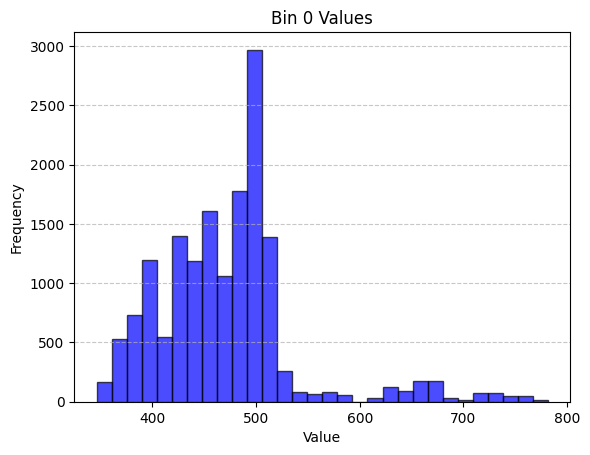

In [1152]:
flattened_array = all_hists_zero_label[:, 0, :, :].ravel()

# Plot histogram
plt.hist(flattened_array, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Bin 0 Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

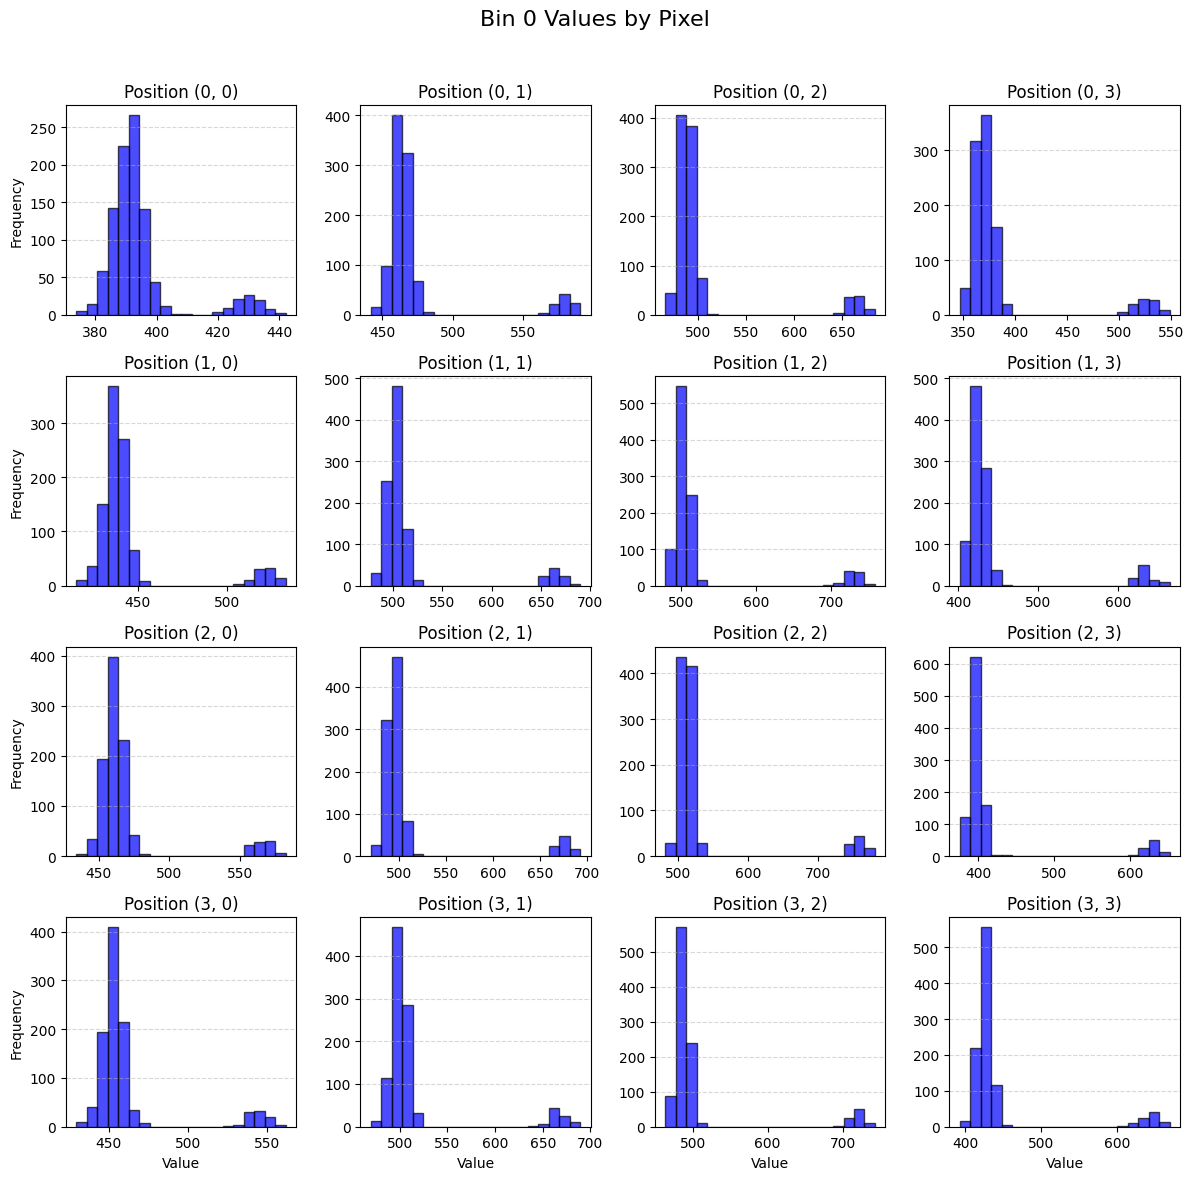

In [1153]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 0, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

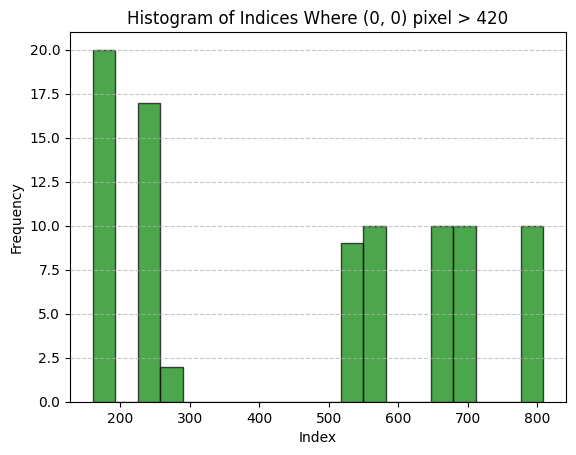

Number of indices where (0, 0) pixel > 420: 88
[160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 230 231 232 234 235 236 237 238 239 250 251 252 253 254 255 256
 257 258 259 520 521 522 523 524 525 526 528 529 550 551 552 553 554 555
 556 557 558 559 670 671 672 673 674 675 676 677 678 679 700 701 702 703
 704 705 706 707 708 709 800 801 802 803 804 805 806 807 808 809]


In [1154]:
# Get the slice [:, 0, 0]
slice_data = all_hists_zero_label[:, 0, :, :][:, 0, 0]

# Get the indices where the condition is met
indices = np.where(slice_data > 420)[0]  # Extract indices along the first dimension

# Plot histogram of the indices
plt.hist(indices, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title("Histogram of Indices Where (0, 0) pixel > 420")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Optional: Print how many indices satisfy the condition
print(f"Number of indices where (0, 0) pixel > 420: {len(indices)}")
# list indices:
print(indices)

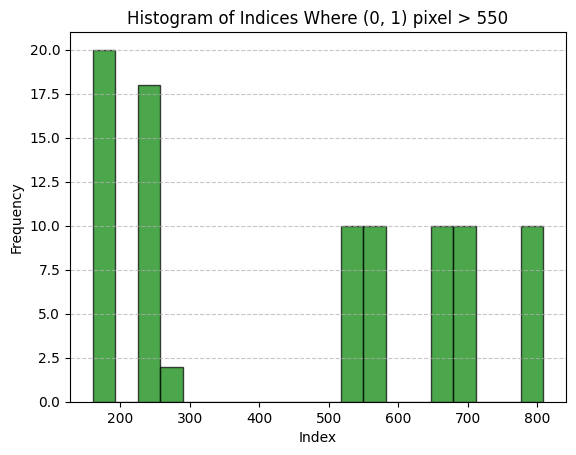

Number of indices where (0, 1) pixel > 550: 90
[160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 230 231 232 233 234 235 236 237 238 239 250 251 252 253 254 255
 256 257 258 259 520 521 522 523 524 525 526 527 528 529 550 551 552 553
 554 555 556 557 558 559 670 671 672 673 674 675 676 677 678 679 700 701
 702 703 704 705 706 707 708 709 800 801 802 803 804 805 806 807 808 809]


In [1155]:
# Get the slice [:, 0, 0]
slice_data = all_hists_zero_label[:, 0, :, :][:, 0, 1]

# Get the indices where the condition is met
indices = np.where(slice_data > 550)[0]  # Extract indices along the first dimension

# Plot histogram of the indices
plt.hist(indices, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title("Histogram of Indices Where (0, 1) pixel > 550")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Optional: Print how many indices satisfy the condition
print(f"Number of indices where (0, 1) pixel > 550: {len(indices)}")
# list indices:
print(indices)

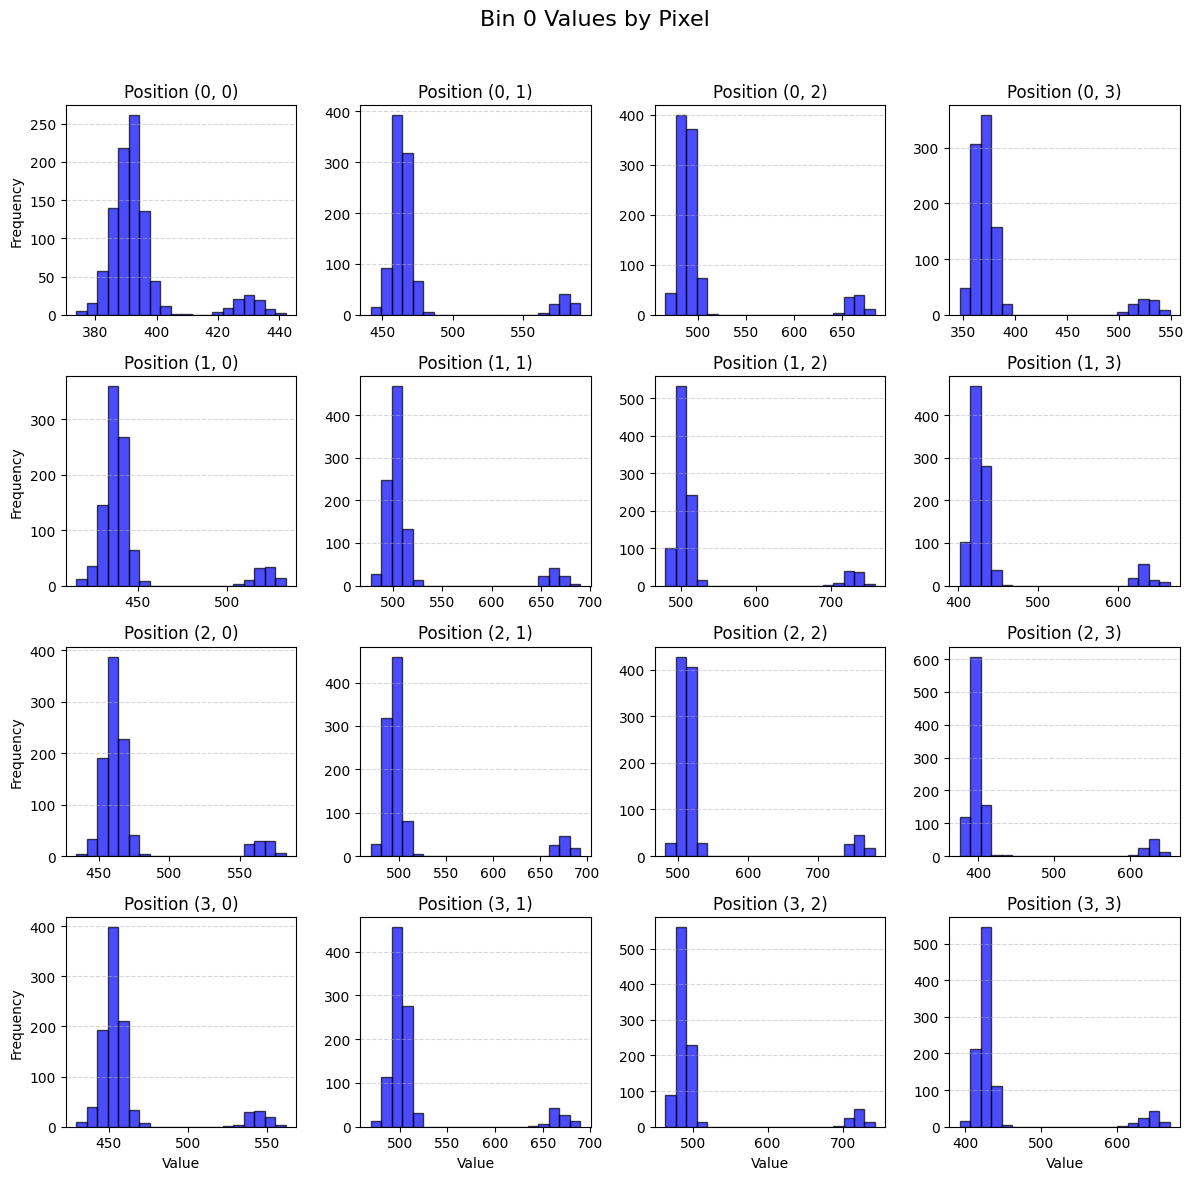

In [1156]:
# Create a mask of shape (1000,) initialized to True
good_mask = np.ones(1000, dtype=bool)

# List of indices to set to False
indices_to_set_false = np.array([185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 
                                  875, 876, 877, 878, 879, 880, 881, 882, 883, 884])

# Set specified indices to False
good_mask[indices_to_set_false] = False


# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 0, :, :][good_mask][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

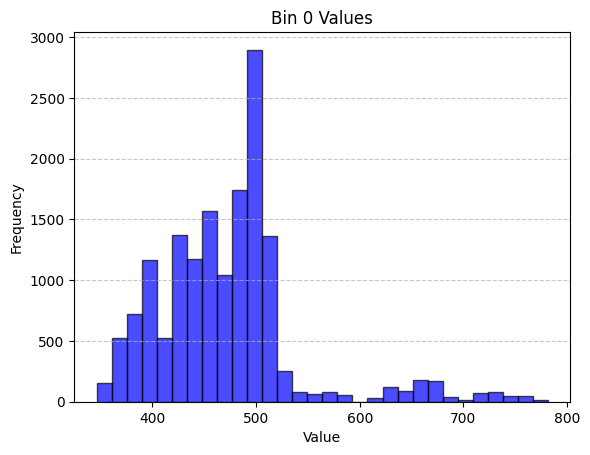

In [1157]:
flattened_array = all_hists_zero_label[:, 0, :, :][good_mask].ravel()

# Plot histogram
plt.hist(flattened_array, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Bin 0 Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### bin 1

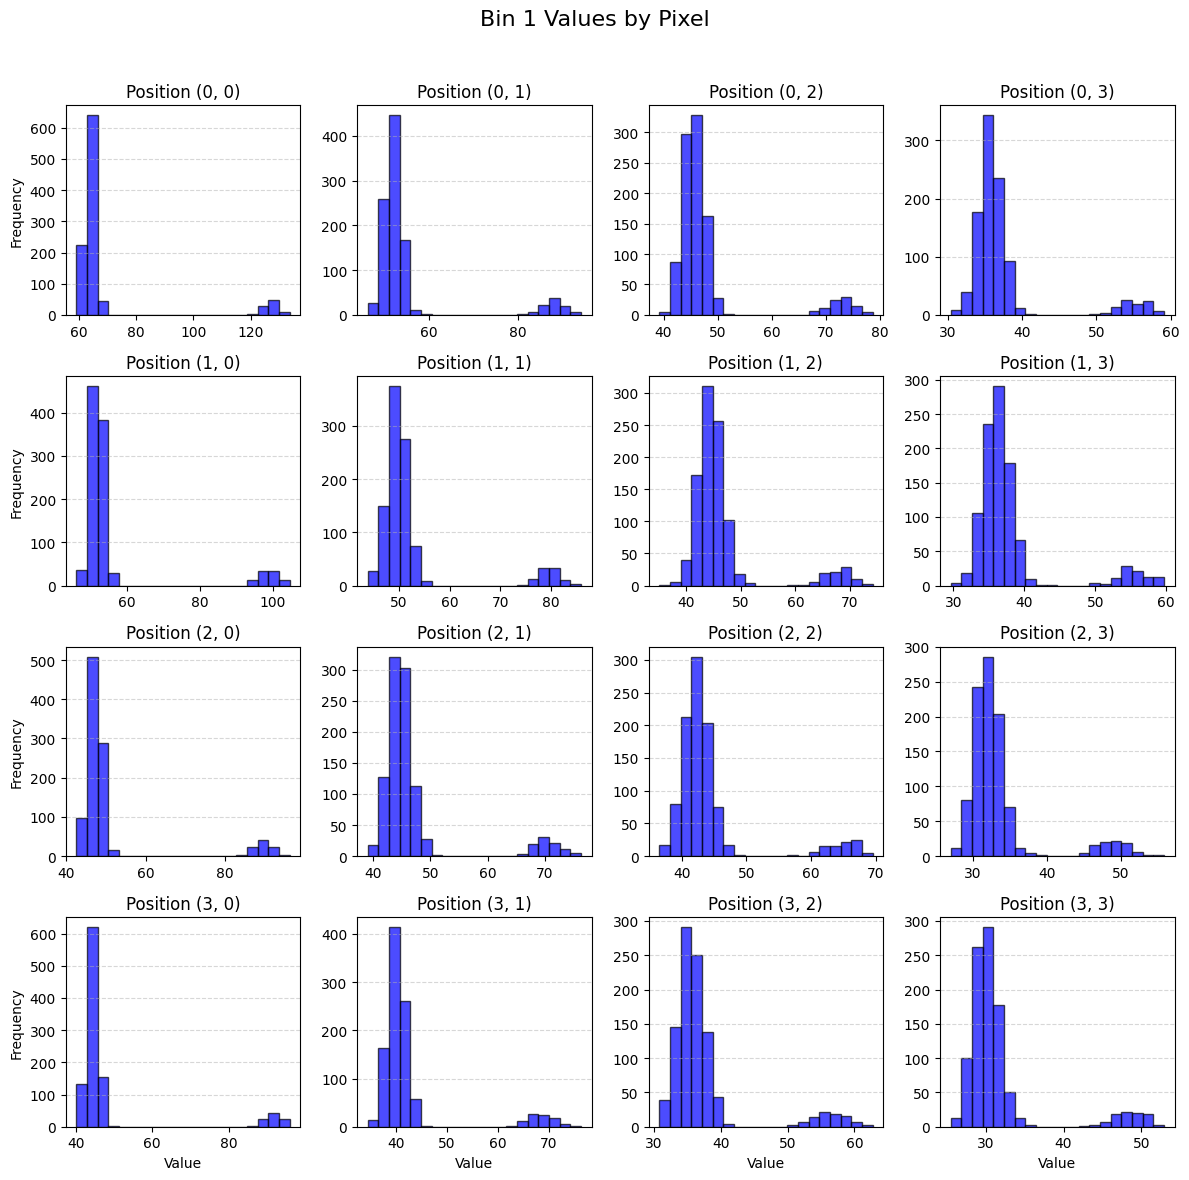

In [1169]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 1 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 1, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

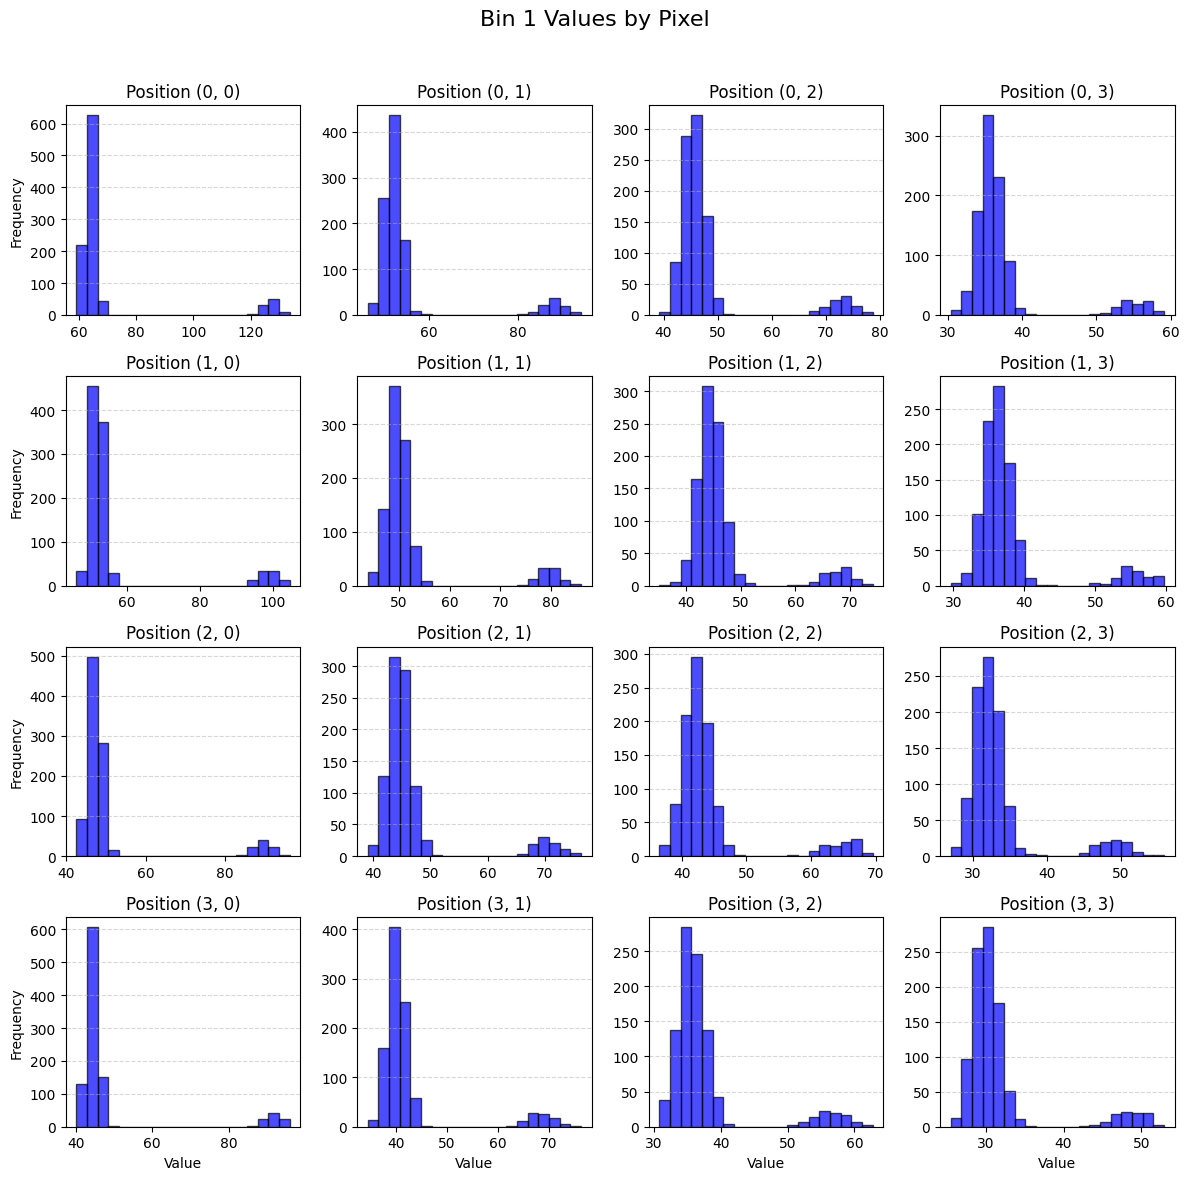

In [1173]:
# Create a mask of shape (1000,) initialized to True
good_mask = np.ones(1000, dtype=bool)

# List of indices to set to False
indices_to_set_false = np.array([185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 
                                  875, 876, 877, 878, 879, 880, 881, 882, 883, 884])

# Set specified indices to False
good_mask[indices_to_set_false] = False


# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 1 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 1, :, :][good_mask][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

### bin 2

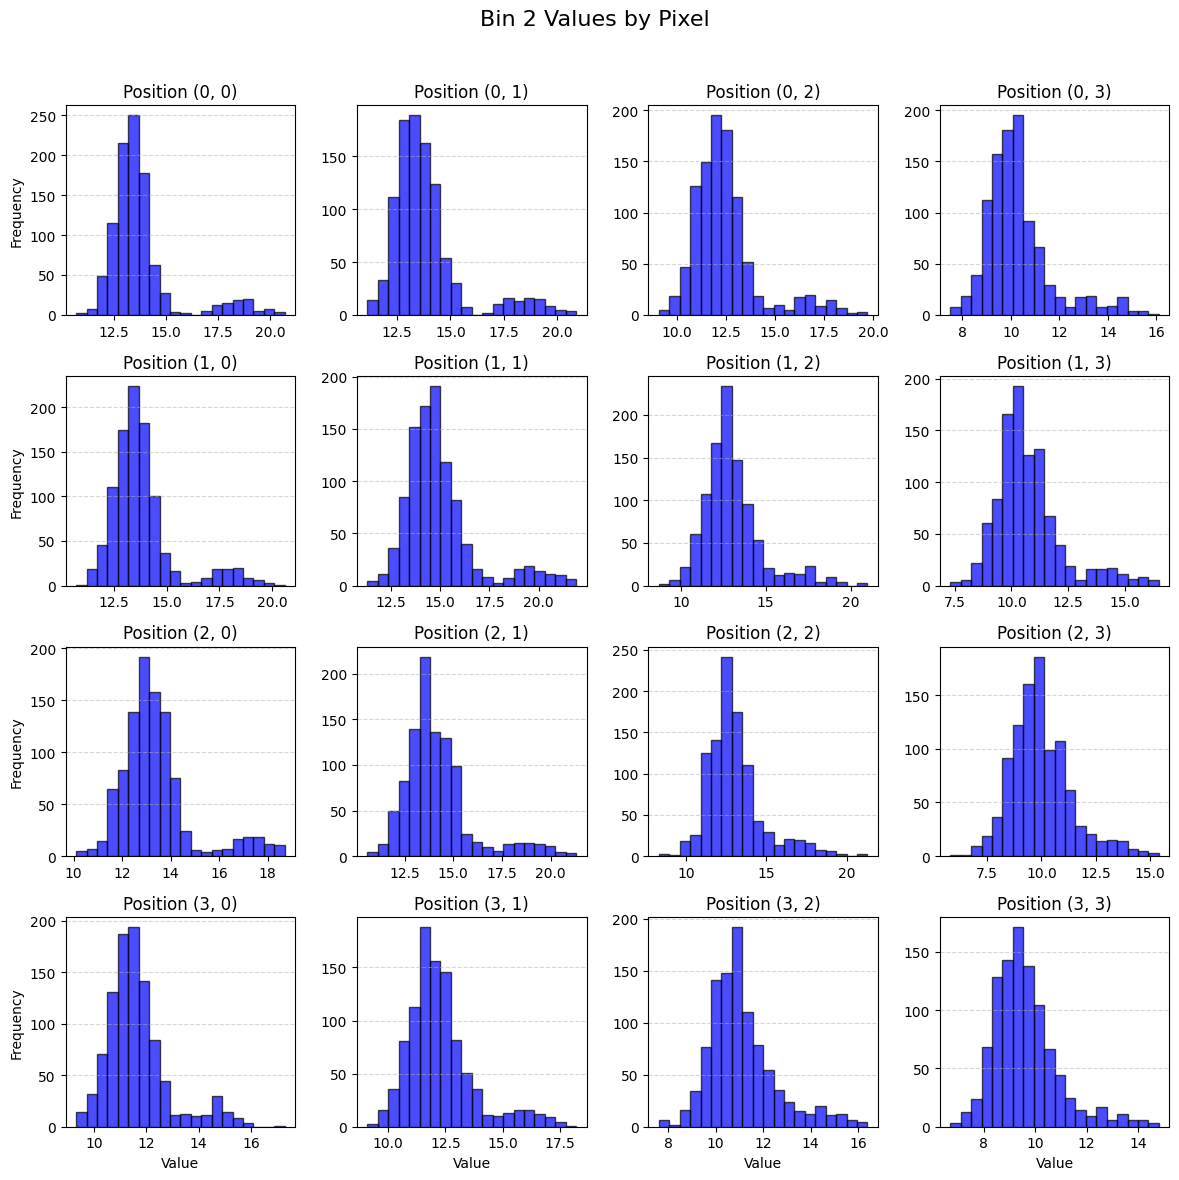

In [1174]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 2 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 2, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

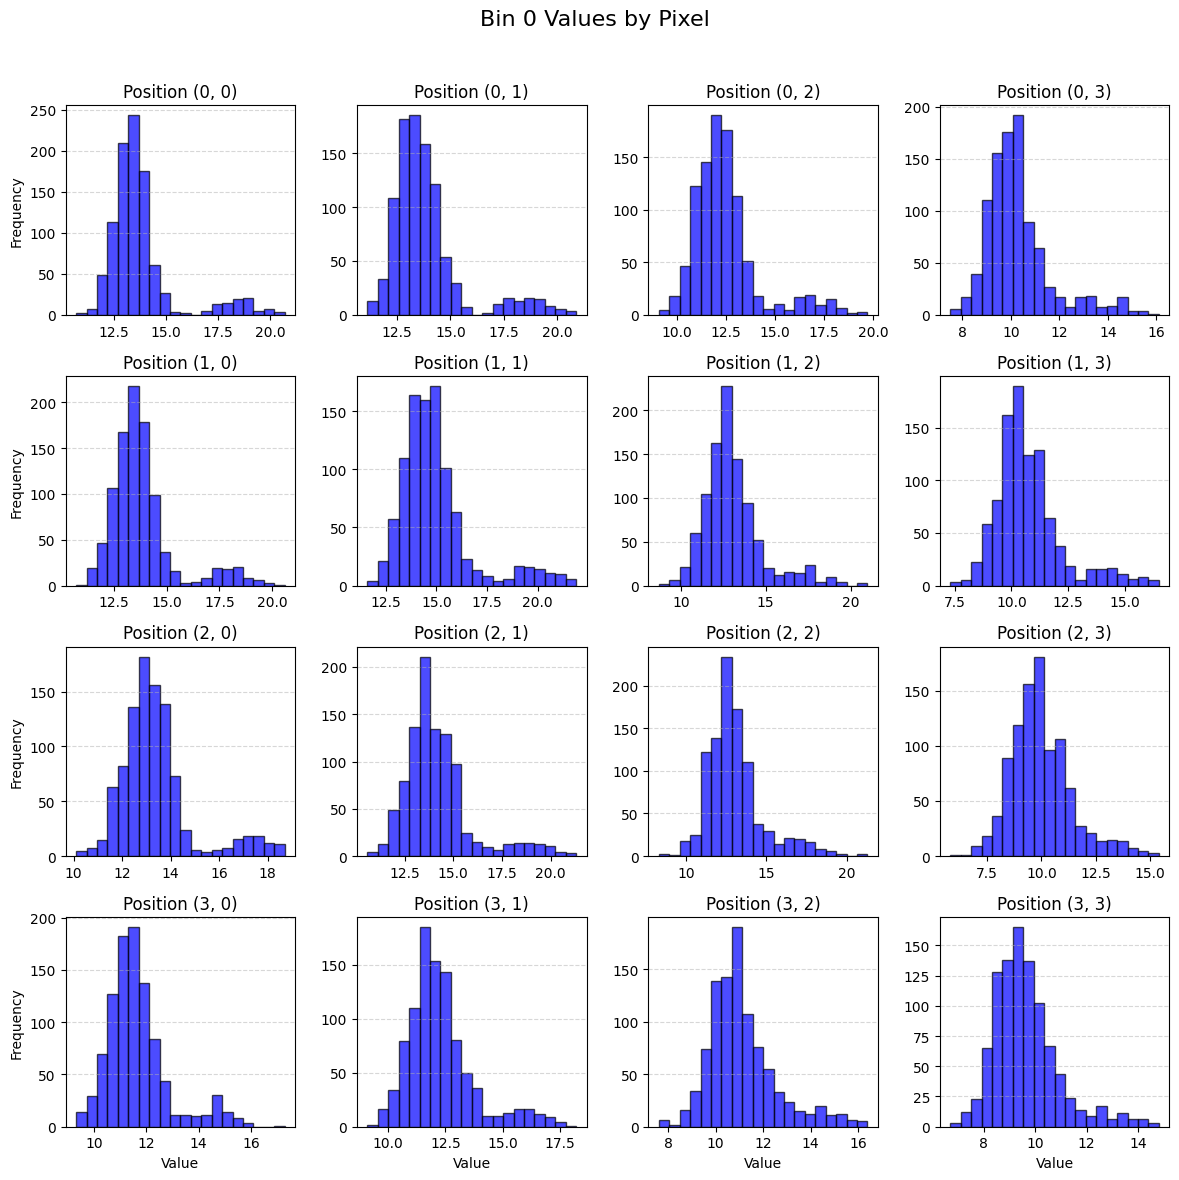

In [1161]:
# Create a mask of shape (1000,) initialized to True
good_mask = np.ones(1000, dtype=bool)

# List of indices to set to False
indices_to_set_false = np.array([185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 
                                  875, 876, 877, 878, 879, 880, 881, 882, 883, 884])

# Set specified indices to False
good_mask[indices_to_set_false] = False


# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 2, :, :][good_mask][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

### bin 3

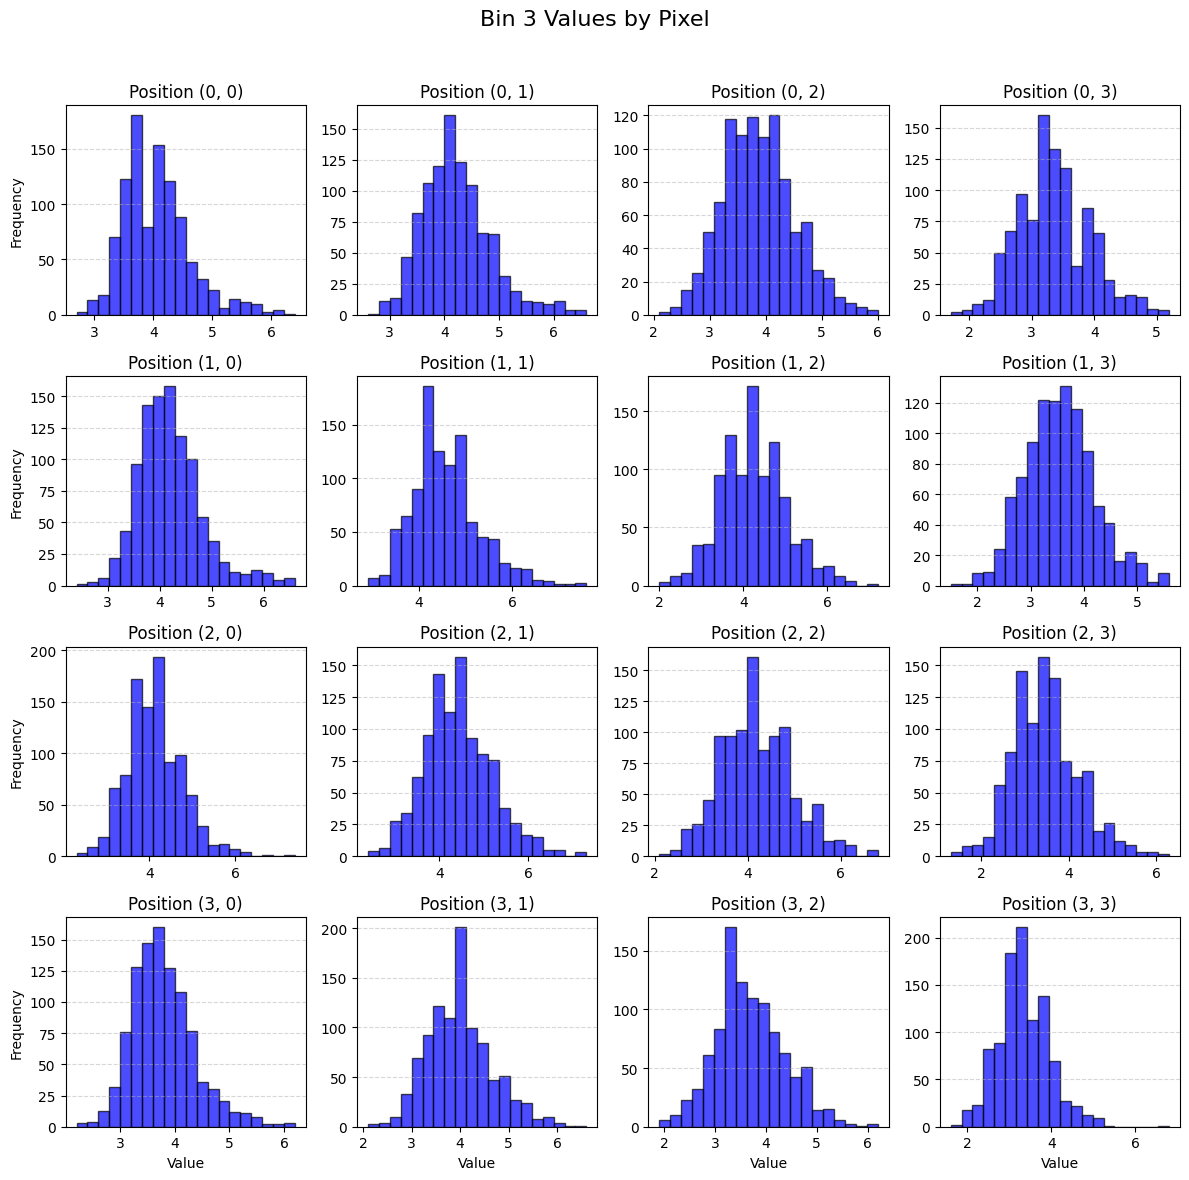

In [1175]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 3 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 3, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

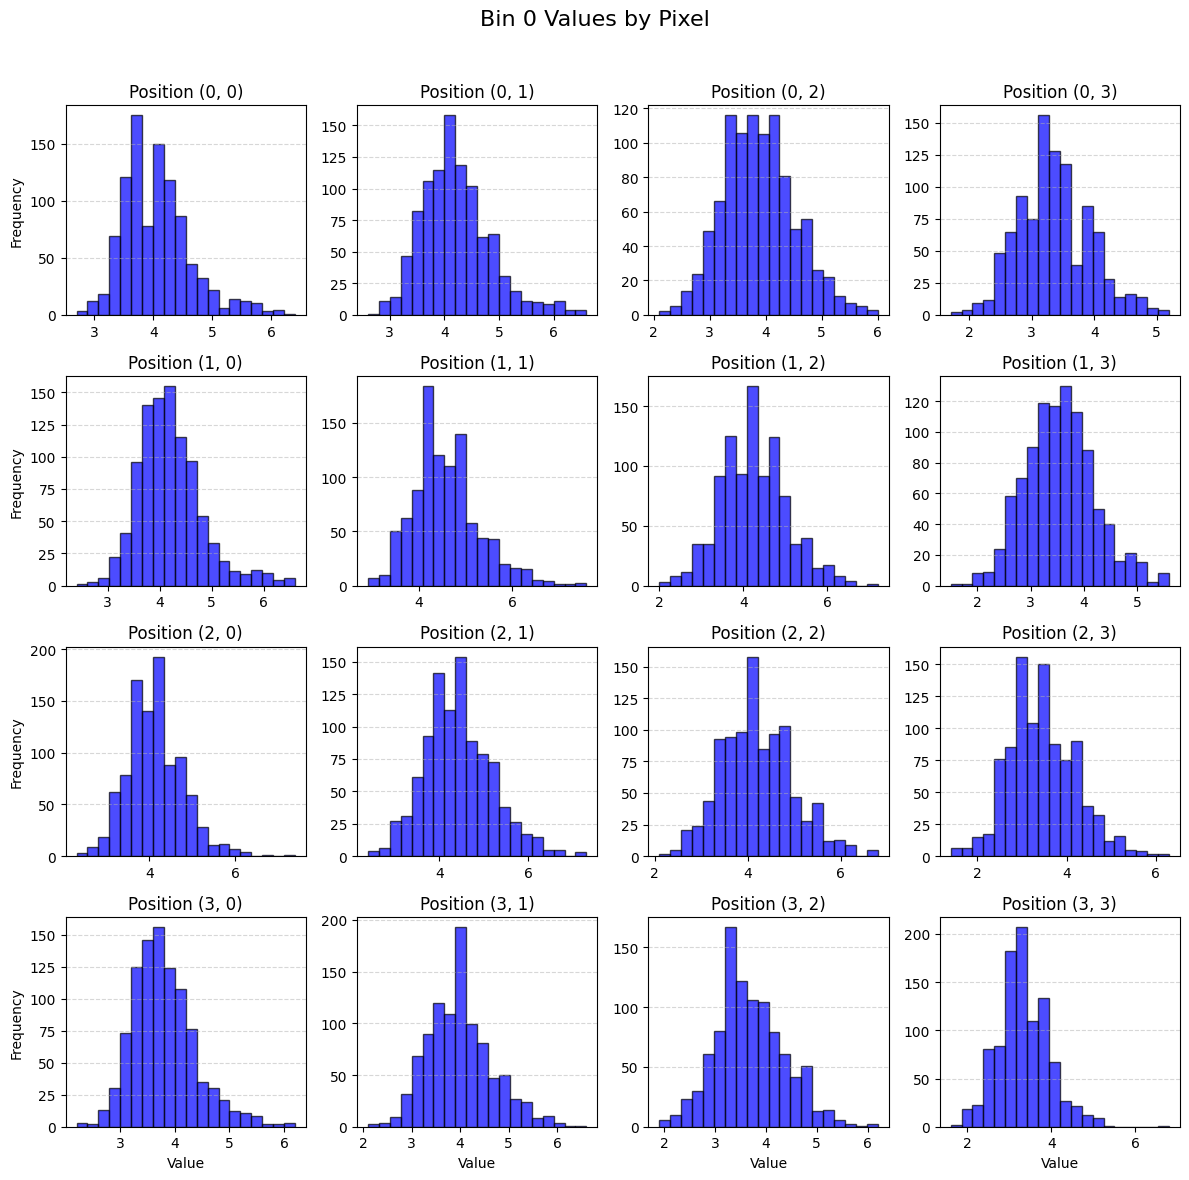

In [1163]:
# Create a mask of shape (1000,) initialized to True
good_mask = np.ones(1000, dtype=bool)

# List of indices to set to False
indices_to_set_false = np.array([185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 
                                  875, 876, 877, 878, 879, 880, 881, 882, 883, 884])

# Set specified indices to False
good_mask[indices_to_set_false] = False


# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, 3, :, :][good_mask][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

### later bins

In [1164]:
bin_num = 6

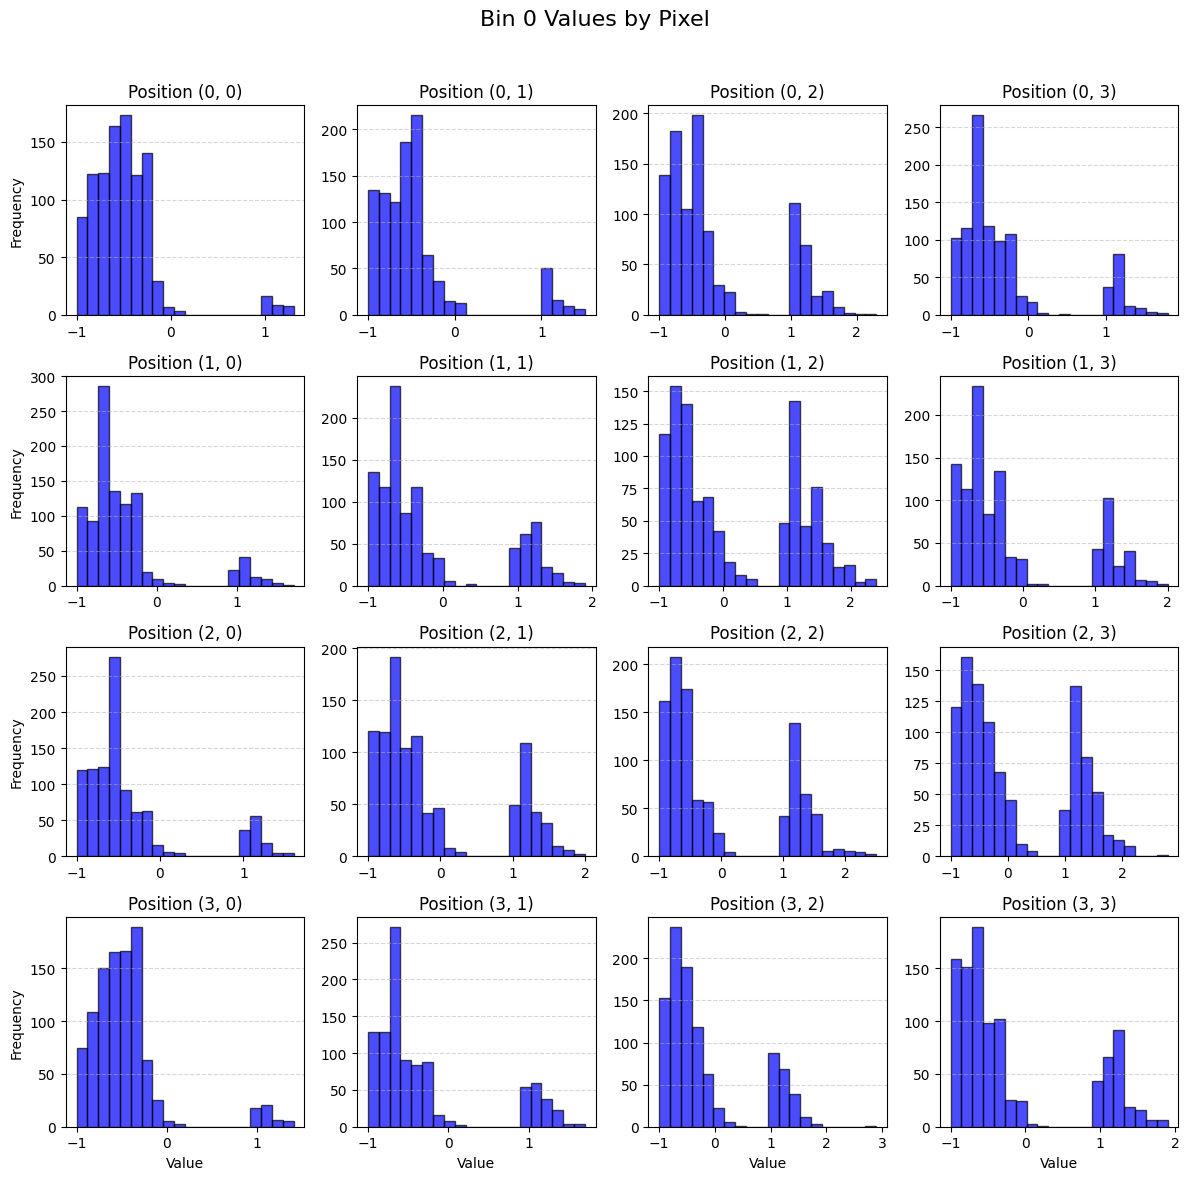

In [1165]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, bin_num, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

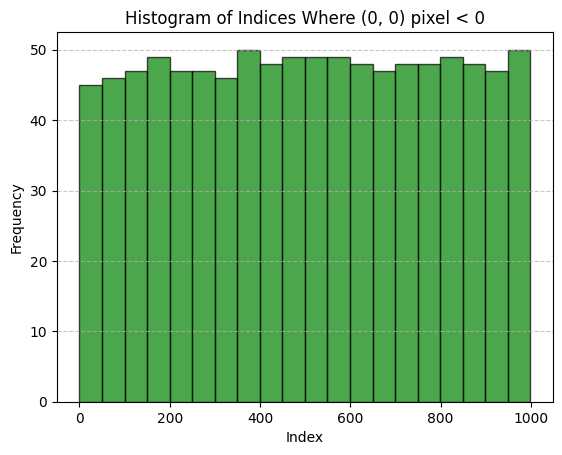

Number of indices where (0, 0) pixel < 0: 957
[0, 2, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 2

In [1166]:
# Get the slice [:, 0, 0]
slice_data = all_hists_zero_label[:, bin_num, :, :][:, 0, 0]

# Get the indices where the condition is met
indices = np.where(slice_data < 0)[0]  # Extract indices along the first dimension

# Plot histogram of the indices
plt.hist(indices, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title("Histogram of Indices Where (0, 0) pixel < 0")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Optional: Print how many indices satisfy the condition
print(f"Number of indices where (0, 0) pixel < 0: {len(indices)}")
# list indices:
print(indices.tolist())

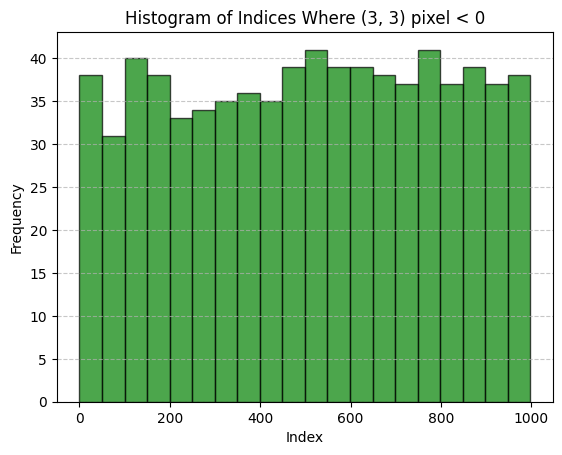

Number of indices where (3, 3) pixel < 0: 745
[0, 1, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 52, 53, 56, 57, 58, 59, 60, 62, 63, 66, 67, 68, 69, 70, 71, 73, 75, 77, 78, 79, 80, 81, 83, 86, 88, 90, 92, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 161, 163, 165, 166, 167, 169, 170, 171, 172, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 206, 207, 210, 211, 212, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 233, 234, 236, 237, 241, 242, 243, 246, 247, 248, 249, 250, 252, 253, 254, 256, 257, 258, 261, 262, 263, 264, 266, 269, 270, 271, 272, 274, 275, 276, 282, 284, 285, 287, 288, 289, 291, 

In [1167]:
# Get the slice [:, 0, 0]
slice_data = all_hists_zero_label[:, bin_num, :, :][:, 3, 3]

# Get the indices where the condition is met
indices = np.where(slice_data < 0)[0]  # Extract indices along the first dimension

# Plot histogram of the indices
plt.hist(indices, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title("Histogram of Indices Where (3, 3) pixel < 0")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Optional: Print how many indices satisfy the condition
print(f"Number of indices where (3, 3) pixel < 0: {len(indices)}")
# list indices:
print(indices.tolist())

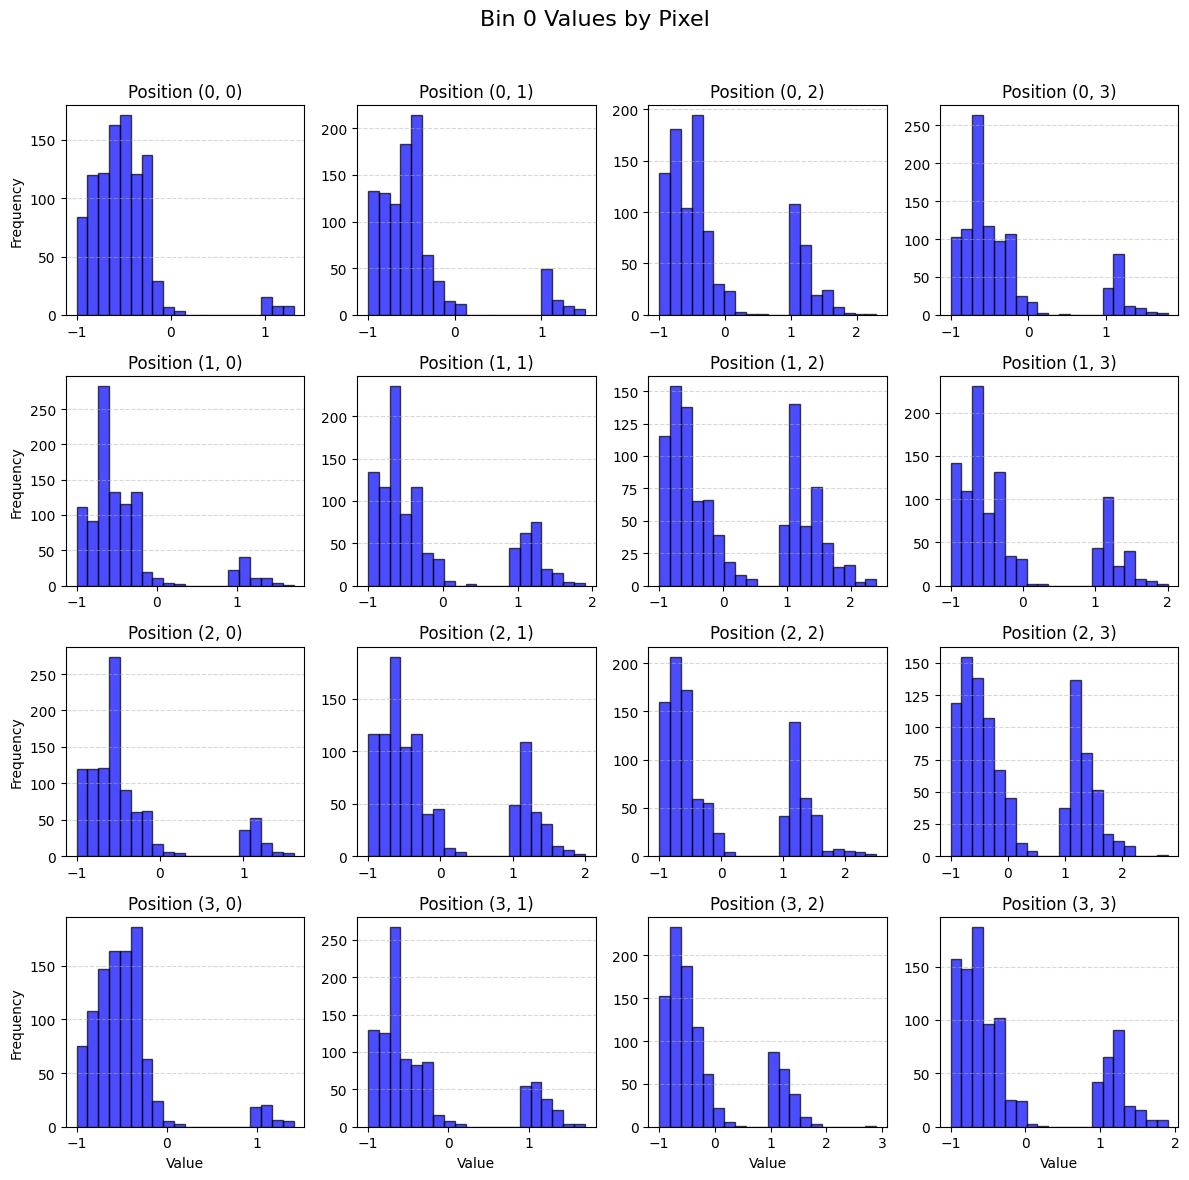

In [1168]:
# Create a mask of shape (1000,) initialized to True
good_mask2 = np.ones(1000, dtype=bool)

# List of indices to set to False
indices_to_set_false = np.array([64, 129, 310, 482, 616, 693, 718, 832, 849, 872, 887, 890])

# Set specified indices to False
good_mask2[indices_to_set_false] = False


# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_zero_label[:, bin_num, :, :][good_mask2][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

## Category 1

In [110]:
labels_mask = np.all(labels == np.array([1, 0, 0]), axis=1)
all_hists_label = all_hists[labels_mask]

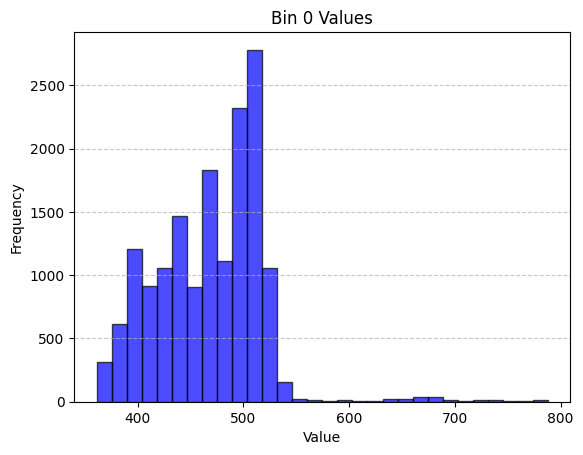

In [111]:
flattened_array = all_hists_label[:, 0, :, :].ravel()

# Plot histogram
plt.hist(flattened_array, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Bin 0 Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

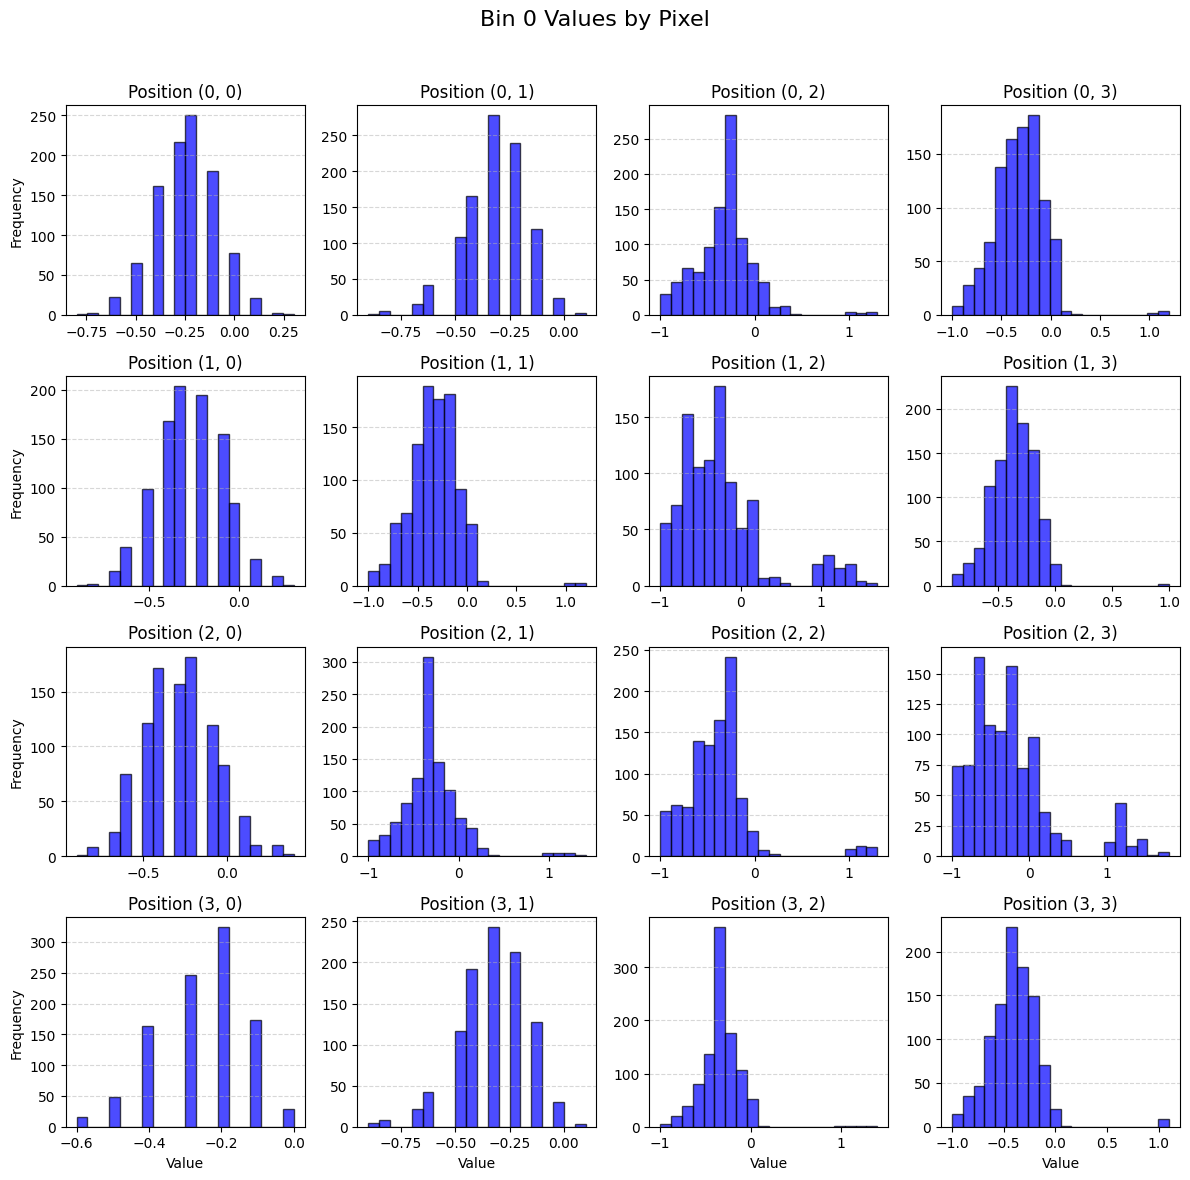

In [112]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_label[:, 10, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

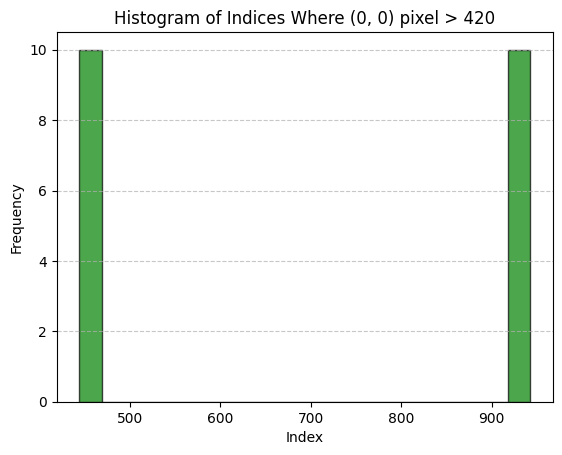

Number of indices where (0, 0) pixel > 420: 20
[444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943]


In [64]:
# Get the slice [:, 0, 0]
slice_data = all_hists_zero_label[:, 0, :, :][:, 0, 0]

# Get the indices where the condition is met
indices = np.where(slice_data > 420)[0]  # Extract indices along the first dimension

# Plot histogram of the indices
plt.hist(indices, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title("Histogram of Indices Where (0, 0) pixel > 420")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Optional: Print how many indices satisfy the condition
print(f"Number of indices where (0, 0) pixel > 420: {len(indices)}")
# list indices:
print(indices.tolist())

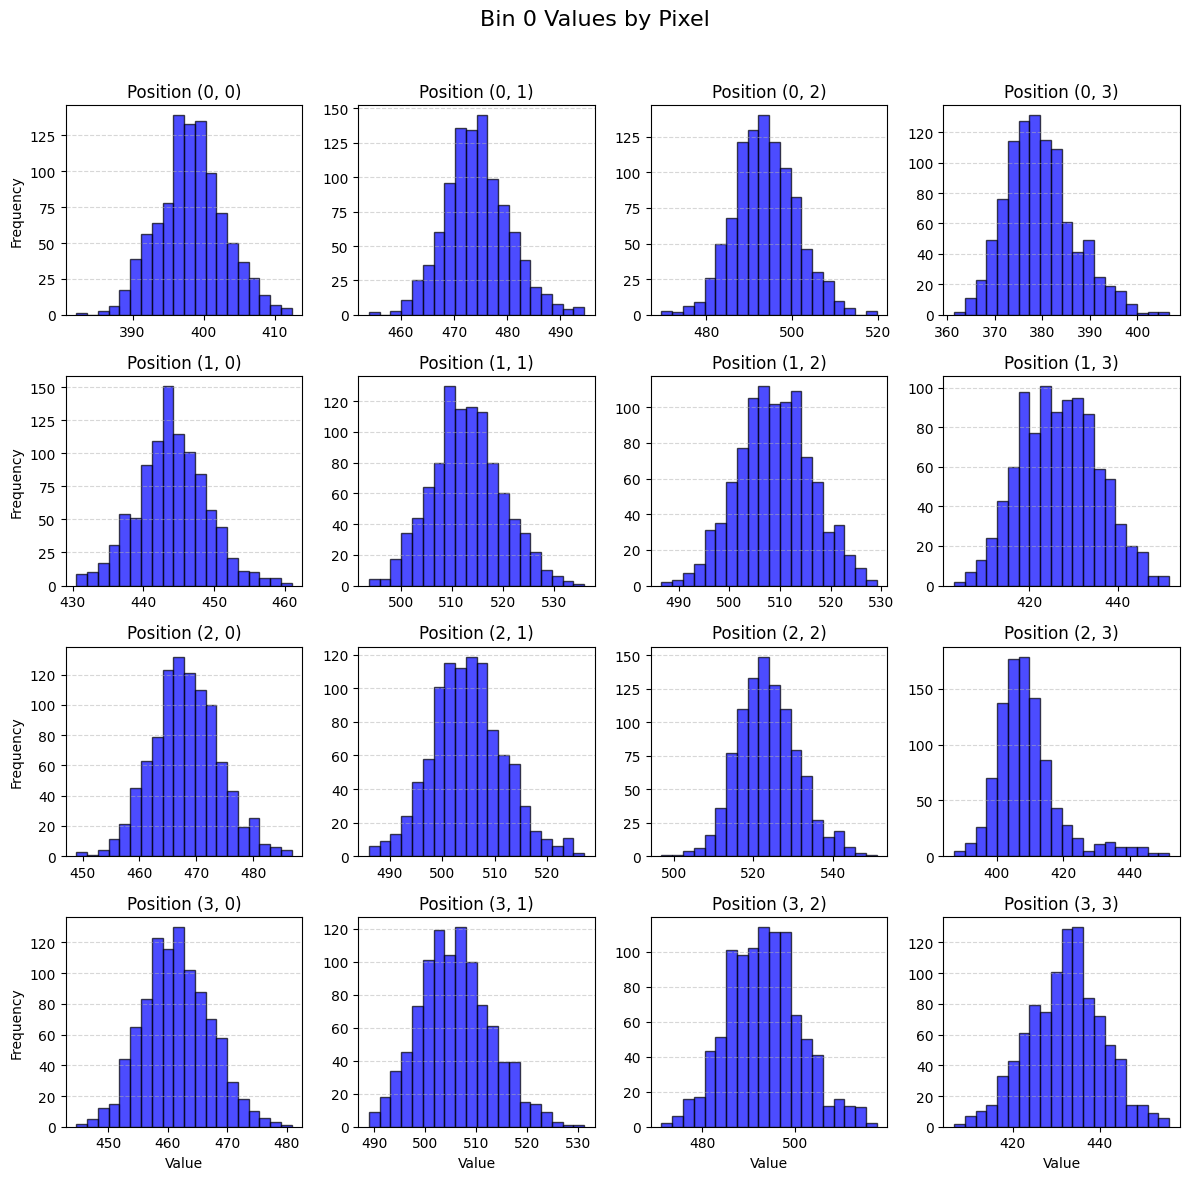

In [65]:
# Create a mask of shape (1000,) initialized to True
good_mask = np.ones(1000, dtype=bool)

# List of indices to set to False
indices_to_set_false = np.array([444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943])

# Set specified indices to False
good_mask[indices_to_set_false] = False


# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = all_hists_label[:, 0, :, :][good_mask][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

## generalized filtering

In [1176]:
data = np.array(all_hists[:, :10, :, :])
# Compute the mean and standard deviation for each position (10, 4, 4) across all samples
mean = data.mean(axis=0)  # Shape: (10, 4, 4)
std = data.std(axis=0)    # Shape: (10, 4, 4)

# Compute the threshold for values being within 3 standard deviations
lower_bound = mean - 4 * std
upper_bound = mean + 4 * std

# Identify samples where all values in (10, 4, 4) are within the bounds
valid_mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=(1, 2, 3))

# Apply the mask to filter the samples
filtered_data = data[valid_mask]

# Check the shapes of the original and filtered arrays
print(f"Original shape: {data.shape}")
print(f"Filtered shape: {filtered_data.shape}")

Original shape: (4000, 10, 4, 4)
Filtered shape: (2059, 10, 4, 4)


Filter std outliers only from the first few bins - later bins are too noisy

In [1177]:
data = np.array(all_hists[:, :10, :, :])

# Compute the mean and standard deviation for each position (10, 4, 4) across all samples
mean = data.mean(axis=0)  # Shape: (10, 4, 4)
std = data.std(axis=0)    # Shape: (10, 4, 4)

# Compute the threshold for values being within 3 standard deviations
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Only consider the first n values along the 10-axis (shape: n x 4 x 4)
n = 4
data_to_check = data[:, :n, :, :]  # Shape: (4000, n, 4, 4)
lower_bound_check = lower_bound[:n, :, :]  # Shape: (n, 4, 4)
upper_bound_check = upper_bound[:n, :, :]  # Shape: (n, 4, 4)

# Identify samples where all values in the first 3 indices along the 10-axis are within bounds
valid_mask = np.all((data_to_check >= lower_bound_check) & (data_to_check <= upper_bound_check), axis=(1, 2, 3))

# Apply the mask to filter the samples
filtered_data = data[valid_mask]

# Check the shapes of the original and filtered arrays
print(f"Original shape: {data.shape}")
print(f"Filtered shape: {filtered_data.shape}")


Original shape: (4000, 10, 4, 4)
Filtered shape: (3683, 10, 4, 4)


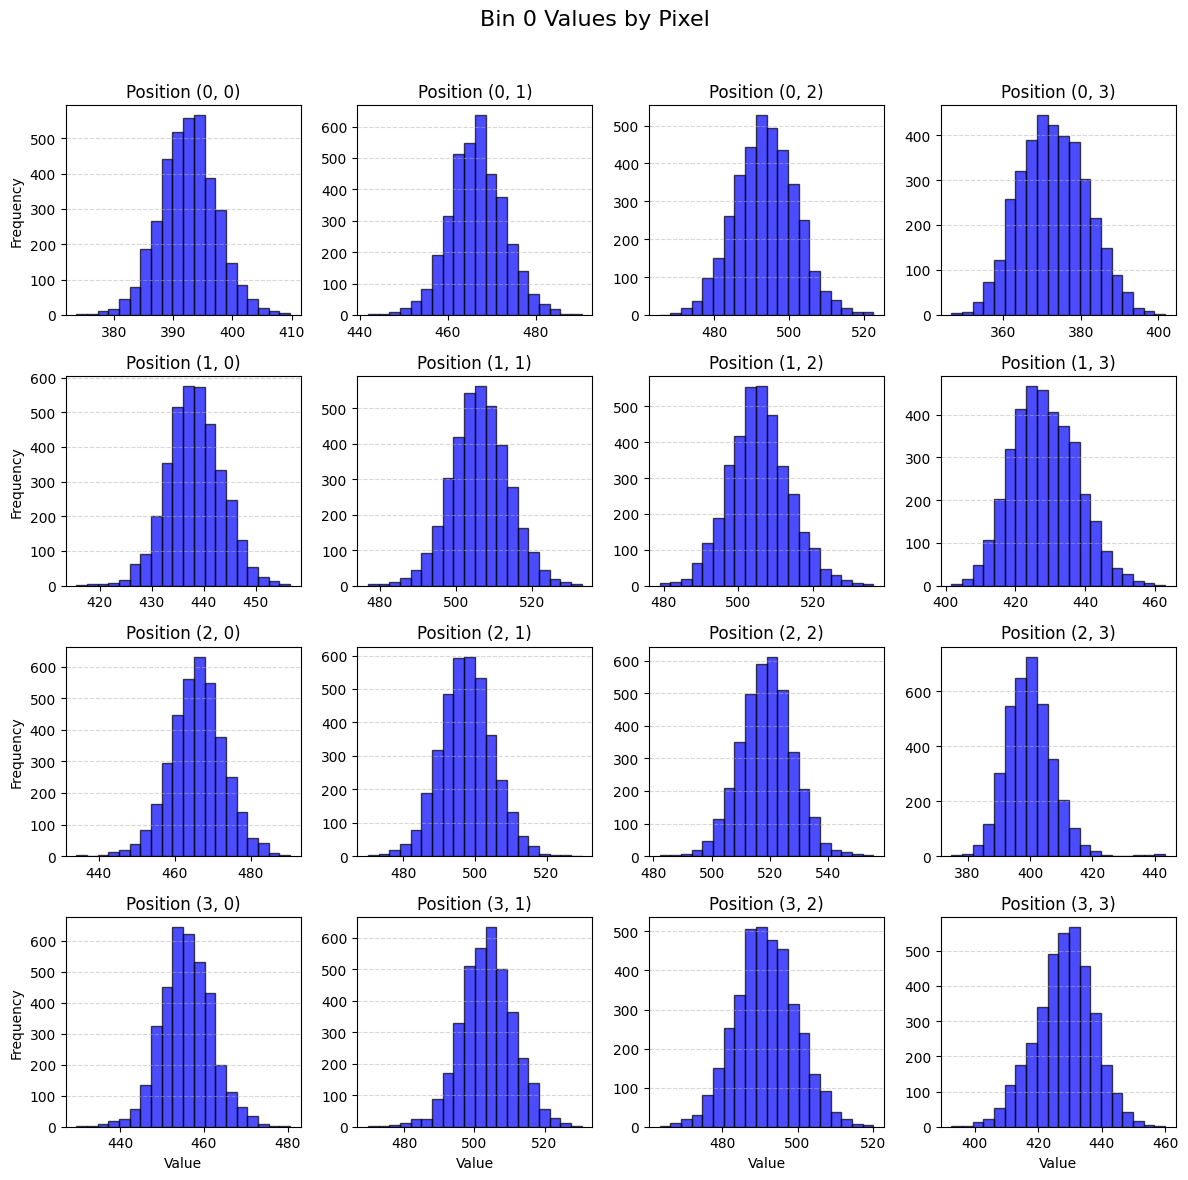

In [1178]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Bin 0 Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data = filtered_data[:, 0, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]
        ax.hist(data, bins=20, color='blue', alpha=0.7, edgecolor='black')
        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

## loading with built-in filtering

In [1223]:
# load dataset
height = 4
width = 4
depth = 24

all_hists = []
labels = []
zero_hists = []

zone_to_label = {
    0: [0, 0, 0],
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1],
    4: [1, 1, 0],
    5: [1, 0, 1],
    6: [0, 1, 1],
    7: [1, 1, 1],
}

In [1224]:
for i in range(4):
    hists = np.load(f'datasets/display-box-12/histograms_{i}.npy')

    hists = hists.reshape(-1, height, width, depth)
    # move depth to the front
    hists = np.moveaxis(hists, -1, 1)

    # look at first 10 bins
    # data = np.array(hists[:, :10, :, :])
    # data = np.array(hists[:, :, :, :])
    data = hists

    # Compute the mean and standard deviation for each position (10, 4, 4) across all samples
    mean = data.mean(axis=0)  # Shape: (10, 4, 4)
    std = data.std(axis=0)    # Shape: (10, 4, 4)

    # Compute the threshold for values being within 3 standard deviations
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Only consider the first n values along the 10-axis (shape: n x 4 x 4)
    n = 4
    data_to_check = data[:, :n, :, :]  # Shape: (4000, n, 4, 4)
    lower_bound_check = lower_bound[:n, :, :]  # Shape: (n, 4, 4)
    upper_bound_check = upper_bound[:n, :, :]  # Shape: (n, 4, 4)

    # Identify samples where all values in the first 3 indices along the 10-axis are within bounds
    valid_mask = np.all((data_to_check >= lower_bound_check) & (data_to_check <= upper_bound_check), axis=(1, 2, 3))

    # Apply the mask to filter the samples
    filtered_data = data[valid_mask]

    hists = filtered_data

    # sliding window mean smoothing
    # Compute the sliding window mean
    k = 5
    sliding_mean = np.array([
        hists[i - k + 1 : i + 1].mean(axis=0)  # Mean of the last k elements
        for i in range(k - 1, len(hists))
    ])
    
    hists = sliding_mean
    
    all_hists.append(hists)

    if i == 0:
        zero_hists.append(hists)

    labels += [zone_to_label[i]] * len(hists)

In [1225]:
zero_hists = np.concatenate(zero_hists, axis=0)
all_hists = np.concatenate(all_hists, axis=0)
labels = np.array(labels)

In [1226]:
print(all_hists.shape)

(3722, 24, 4, 4)


## class comparison

In [1227]:
labels_mask_0 = np.all(labels == np.array([0, 0, 0]), axis=1)
labels_mask_1 = np.all(labels == np.array([1, 0, 0]), axis=1)
labels_mask_2 = np.all(labels == np.array([0, 1, 0]), axis=1)
labels_mask_3 = np.all(labels == np.array([0, 0, 1]), axis=1)

In [1228]:
bin_num = 7

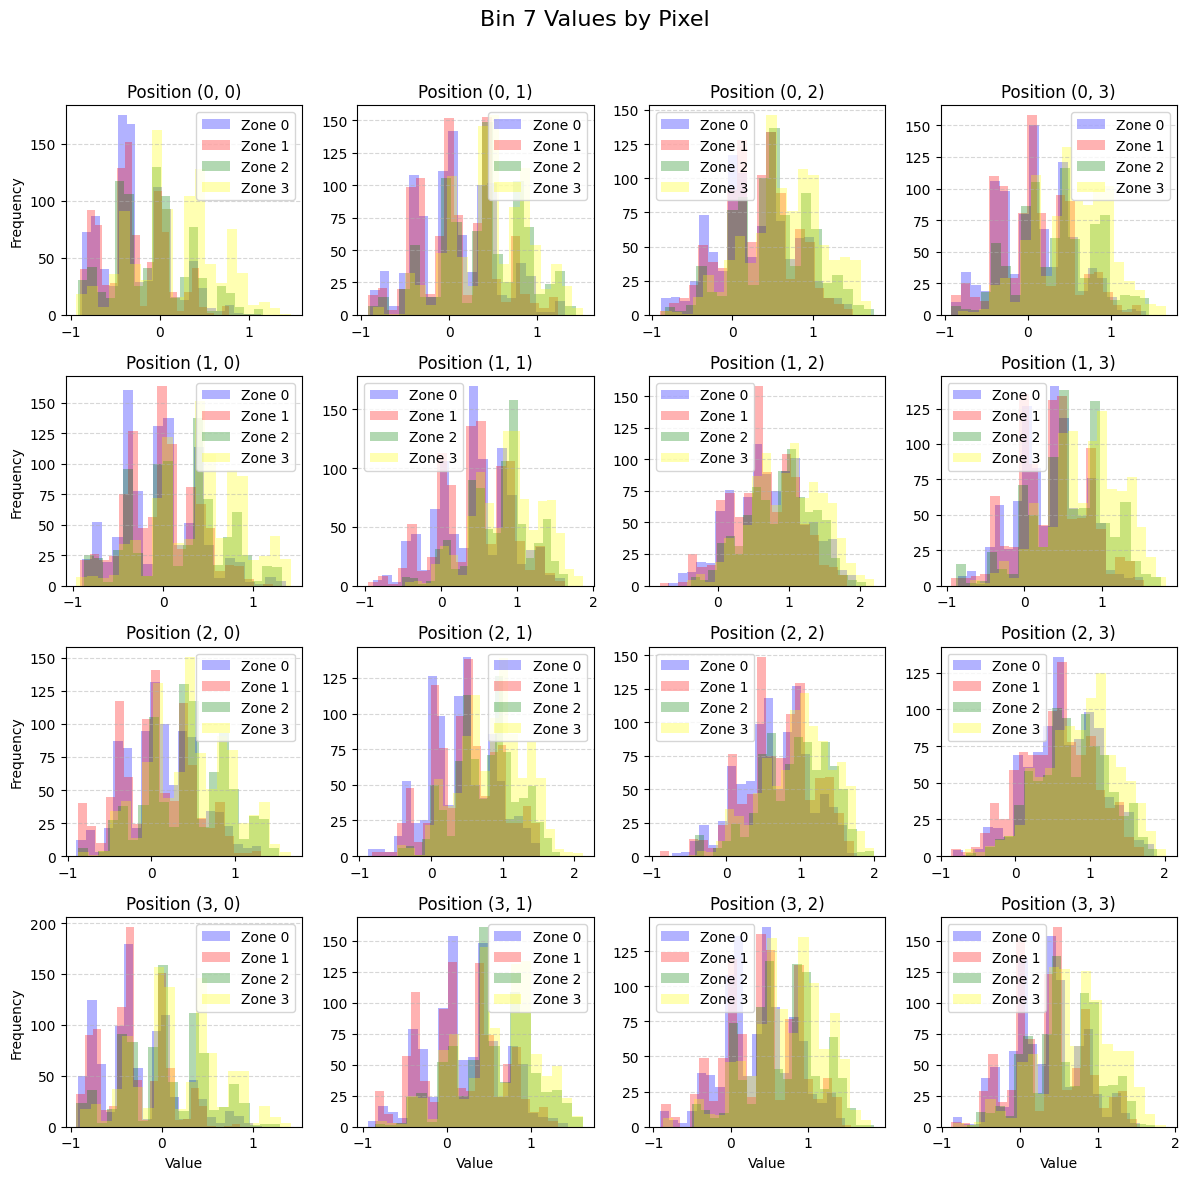

In [1229]:
# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle(f"Bin {bin_num} Values by Pixel", fontsize=16)

for i in range(4):
    for j in range(4):
        # Get the samples for the current position (i, j)
        data_0 = all_hists[labels_mask_0][:, bin_num, :, :][:, i, j]
        data_1 = all_hists[labels_mask_1][:, bin_num, :, :][:, i, j]
        data_2 = all_hists[labels_mask_2][:, bin_num, :, :][:, i, j]
        data_3 = all_hists[labels_mask_3][:, bin_num, :, :][:, i, j]
        
        # Plot the histogram in the corresponding subplot
        ax = axes[i, j]

        ax.hist(data_0, bins=20, color='blue', alpha=0.3)
        ax.hist(data_1, bins=20, color='red', alpha=0.3)
        ax.hist(data_2, bins=20, color='green', alpha=0.3)
        ax.hist(data_3, bins=20, color='yellow', alpha=0.3)

        ax.set_title(f"Position ({i}, {j})")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend(["Zone 0", "Zone 1", "Zone 2", "Zone 3"])
        
        # Optional: Add axis labels for specific subplots
        if i == 3:  # Label x-axis for the bottom row
            ax.set_xlabel("Value")
        if j == 0:  # Label y-axis for the first column
            ax.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

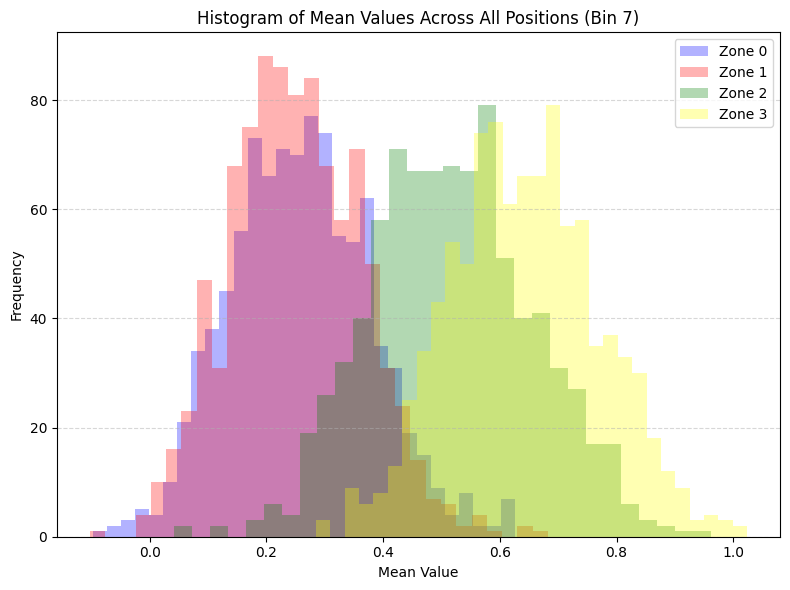

In [1230]:
# mean over bins

# Initialize arrays to store the mean values
mean_data_0 = np.mean(all_hists[labels_mask_0][:, bin_num, :, :], axis=(1, 2))
mean_data_1 = np.mean(all_hists[labels_mask_1][:, bin_num, :, :], axis=(1, 2))
mean_data_2 = np.mean(all_hists[labels_mask_2][:, bin_num, :, :], axis=(1, 2))
mean_data_3 = np.mean(all_hists[labels_mask_3][:, bin_num, :, :], axis=(1, 2))

# Plot a single histogram of the mean values
plt.figure(figsize=(8, 6))
plt.hist(mean_data_0, bins=30, color='blue', alpha=0.3, label="Zone 0")
plt.hist(mean_data_1, bins=30, color='red', alpha=0.3, label="Zone 1")
plt.hist(mean_data_2, bins=30, color='green', alpha=0.3, label="Zone 2")
plt.hist(mean_data_3, bins=30, color='yellow', alpha=0.3, label="Zone 3")

# Add labels, legend, and title
plt.xlabel("Mean Value")
plt.ylabel("Frequency")
plt.title(f"Histogram of Mean Values Across All Positions (Bin {bin_num})")
plt.legend()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


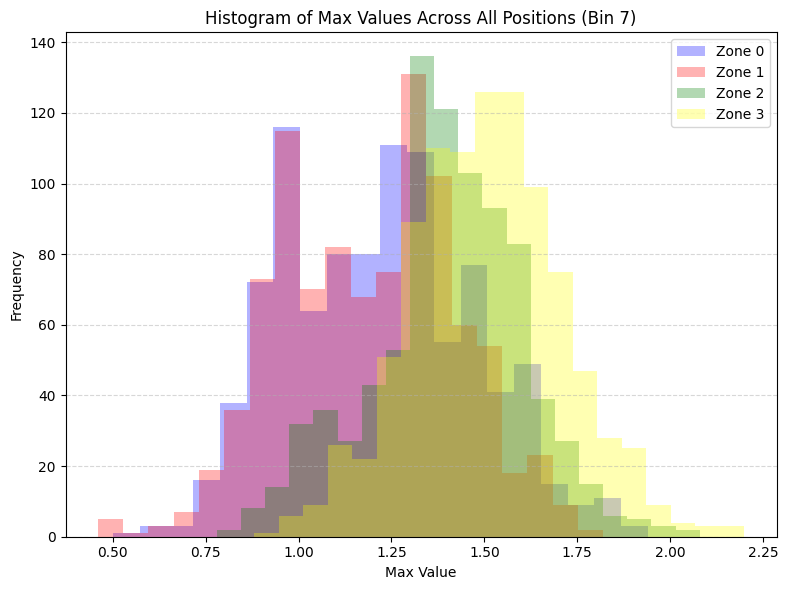

In [1231]:
# max over bins
max_data_0 = np.max(all_hists[labels_mask_0][:, bin_num, :, :], axis=(1, 2))
max_data_1 = np.max(all_hists[labels_mask_1][:, bin_num, :, :], axis=(1, 2))
max_data_2 = np.max(all_hists[labels_mask_2][:, bin_num, :, :], axis=(1, 2))
max_data_3 = np.max(all_hists[labels_mask_3][:, bin_num, :, :], axis=(1, 2))

# Plot a single histogram of the max values
plt.figure(figsize=(8, 6))
plt.hist(max_data_0, bins=20, color='blue', alpha=0.3, label="Zone 0")
plt.hist(max_data_1, bins=20, color='red', alpha=0.3, label="Zone 1")
plt.hist(max_data_2, bins=20, color='green', alpha=0.3, label="Zone 2")
plt.hist(max_data_3, bins=20, color='yellow', alpha=0.3, label="Zone 3")

# Add labels, legend, and title
plt.xlabel("Max Value")
plt.ylabel("Frequency")
plt.title(f"Histogram of Max Values Across All Positions (Bin {bin_num})")
plt.legend()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


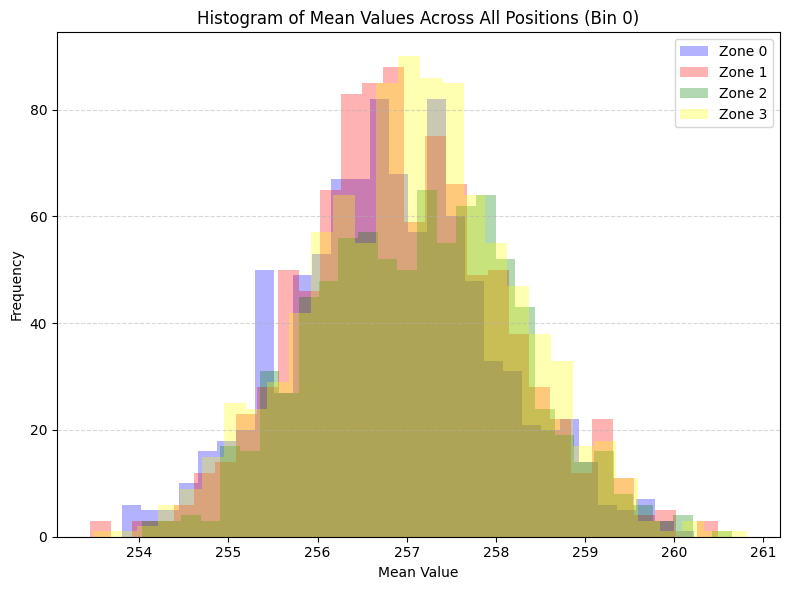

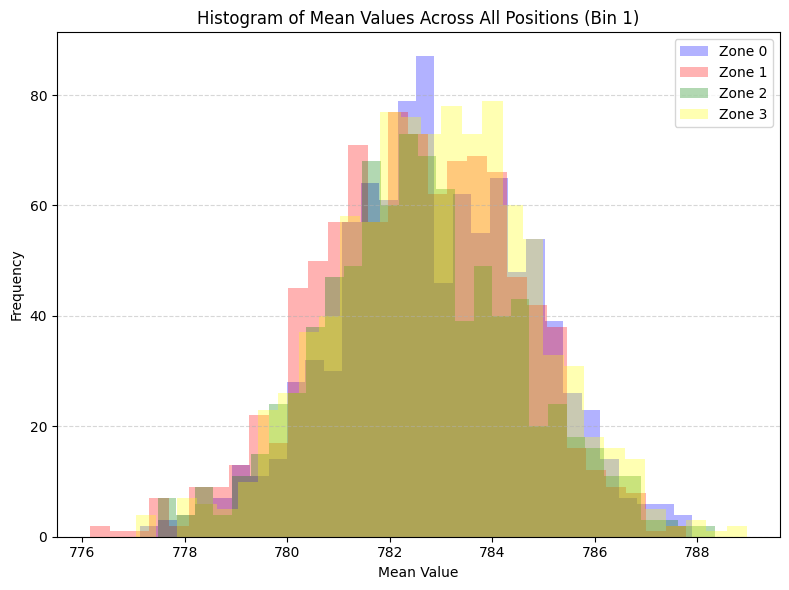

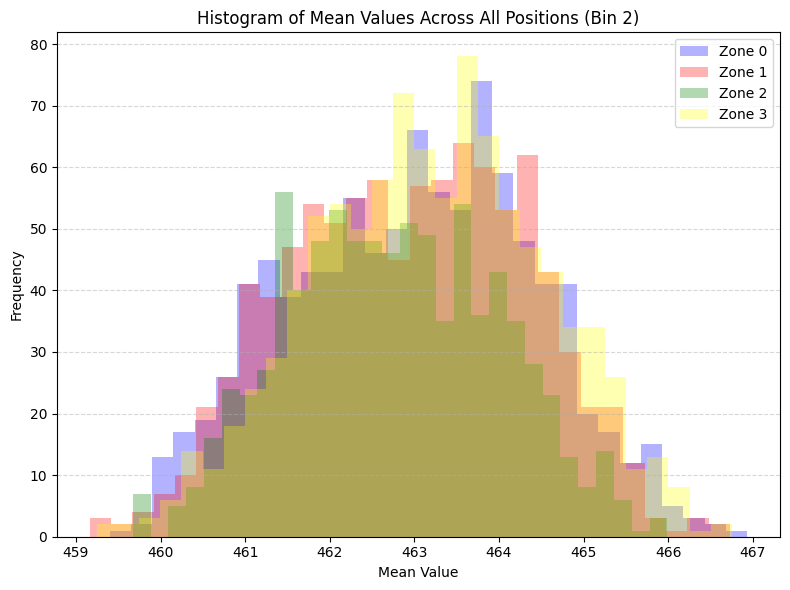

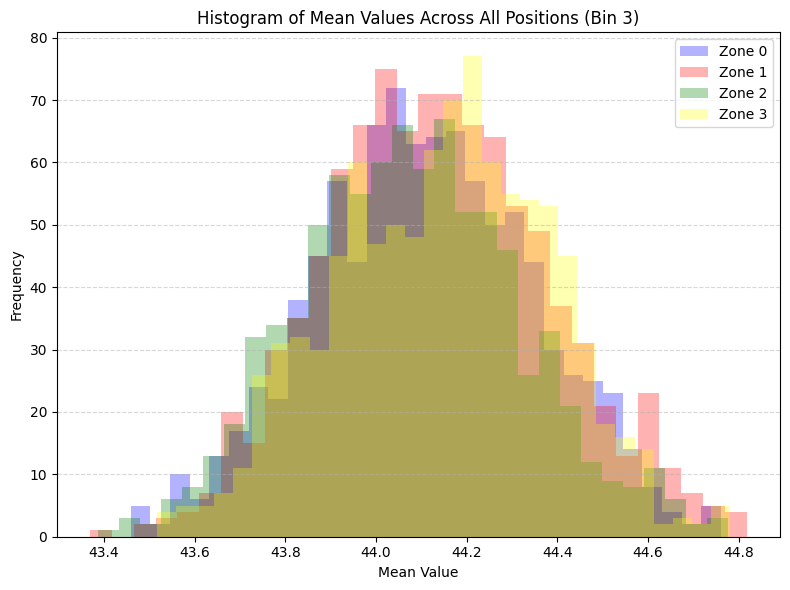

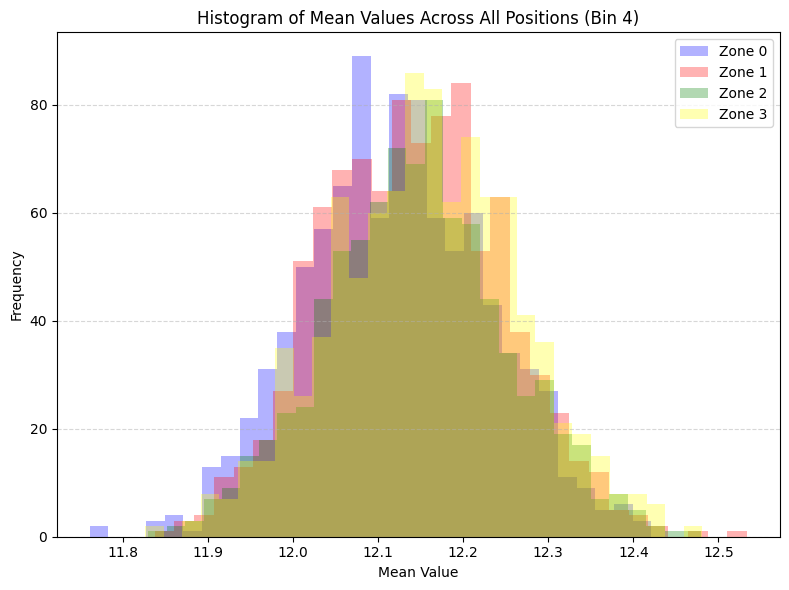

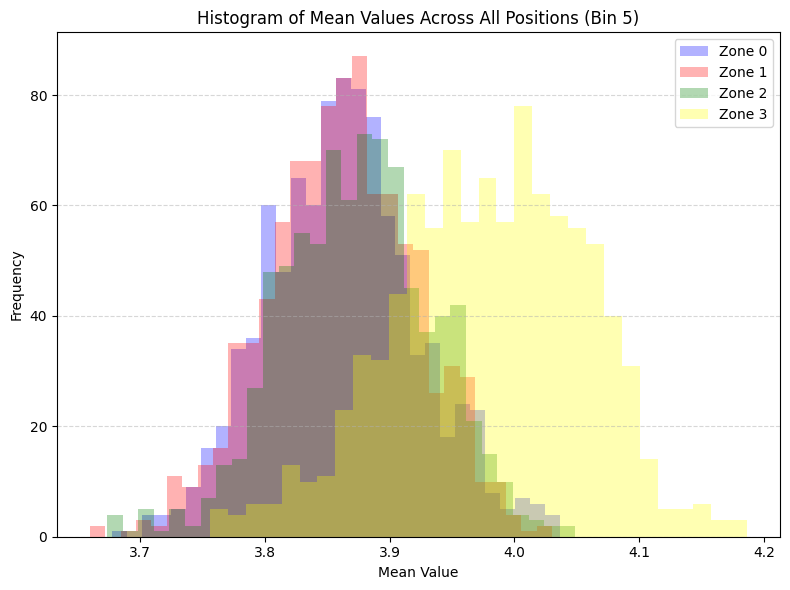

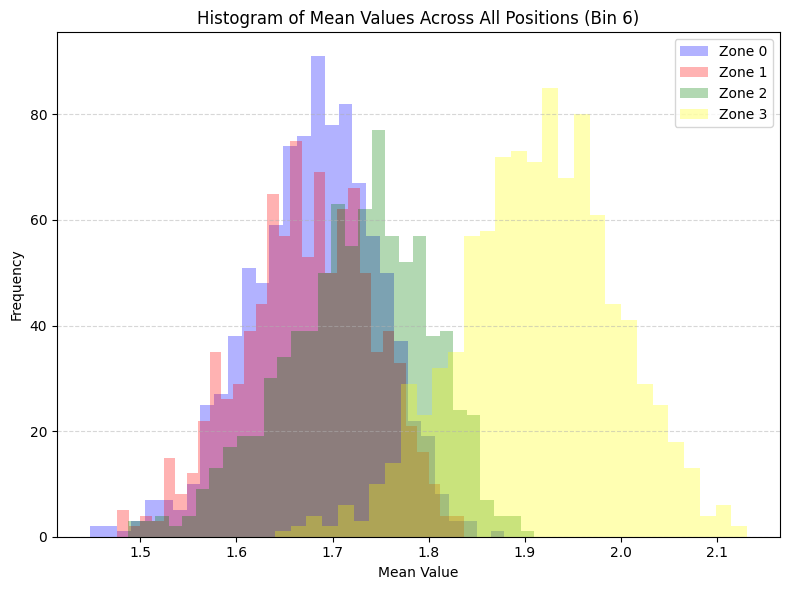

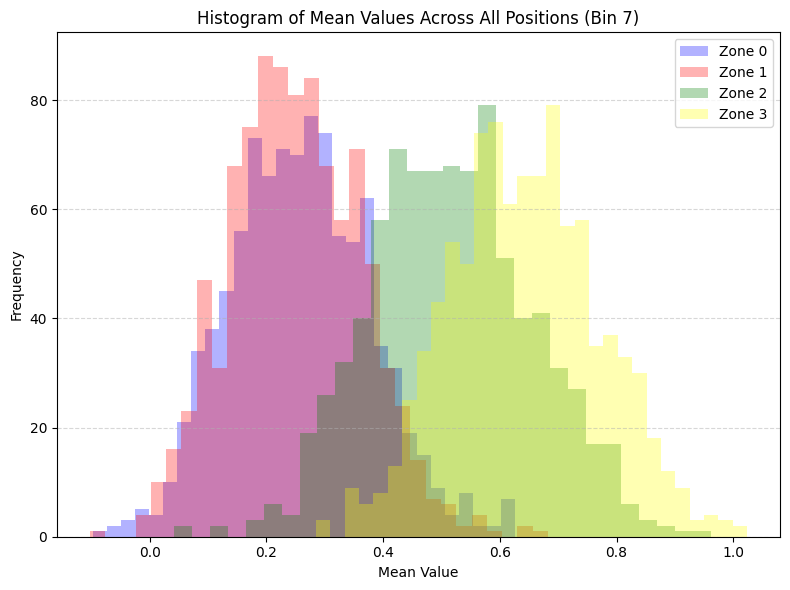

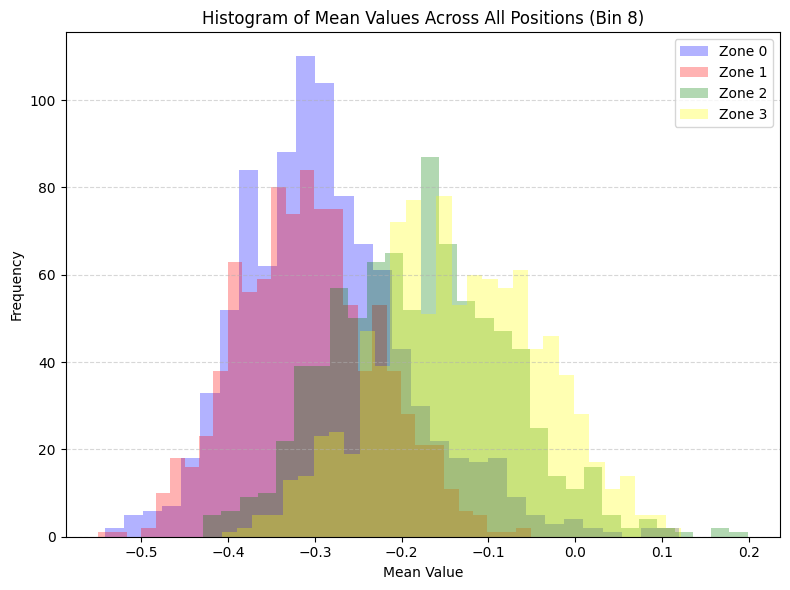

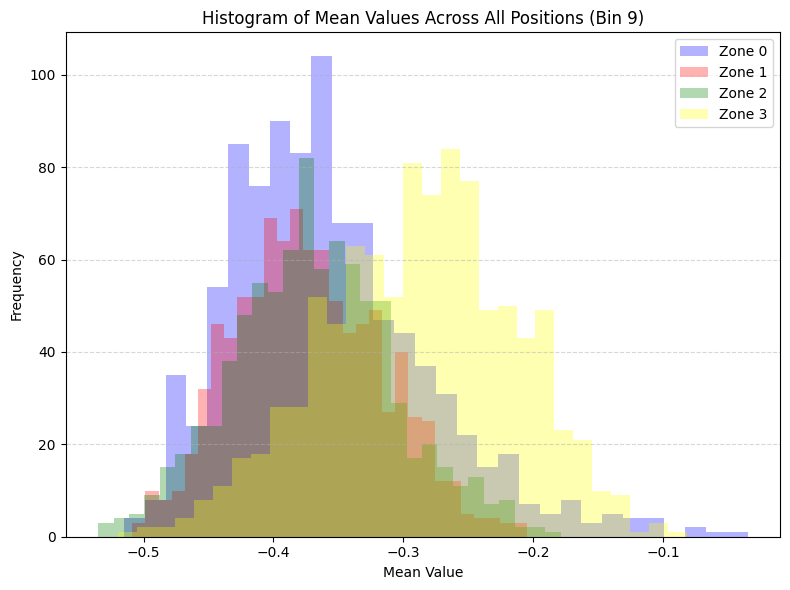

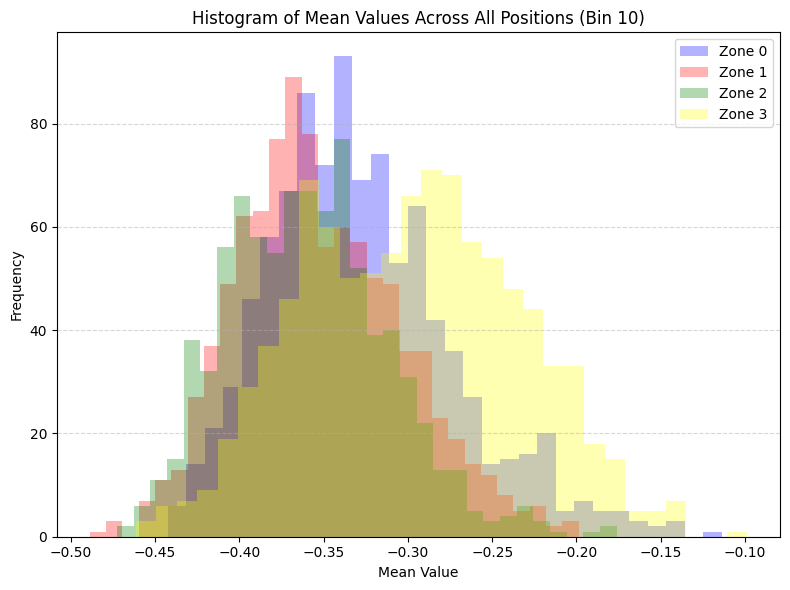

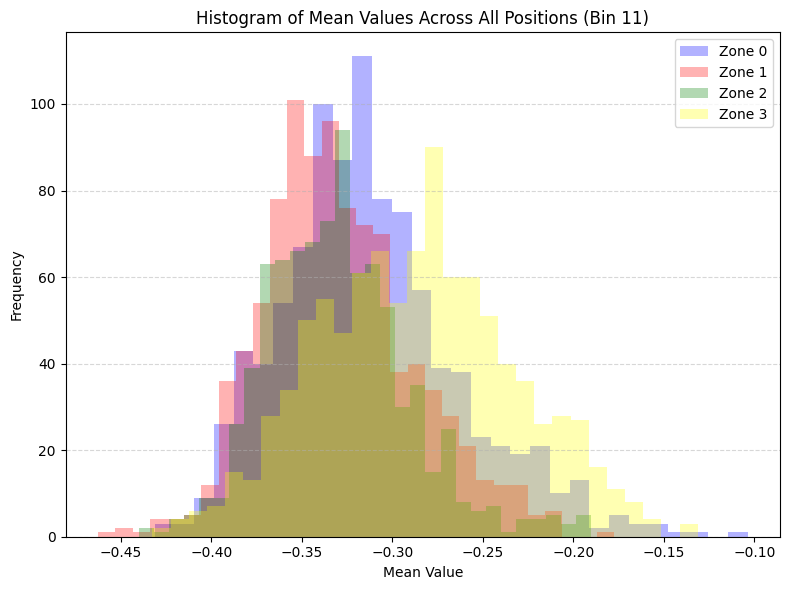

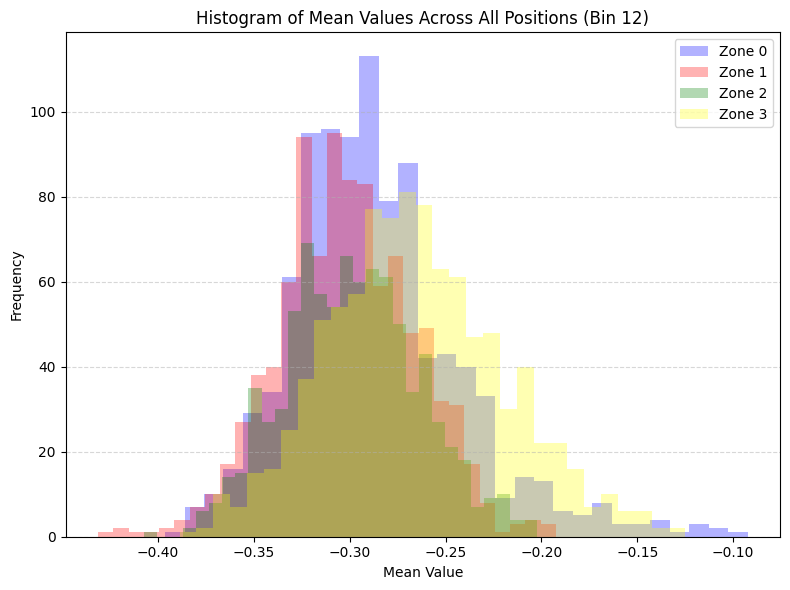

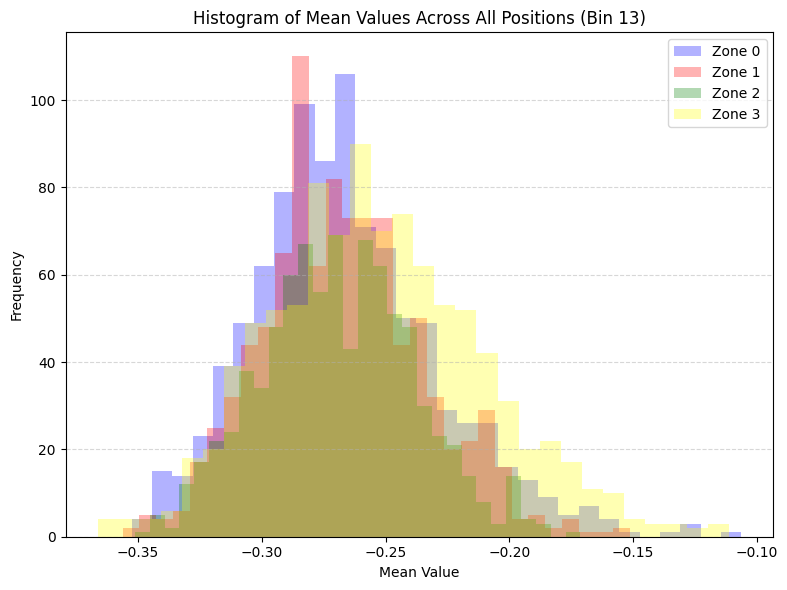

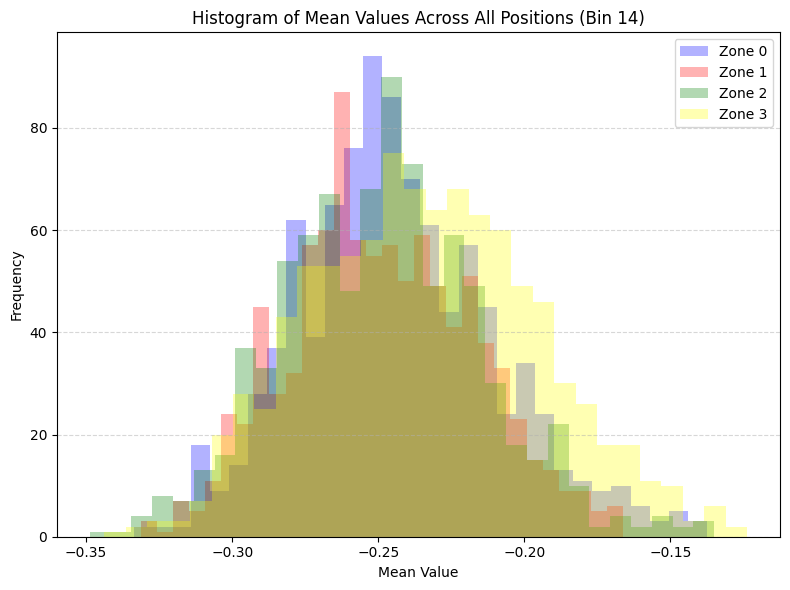

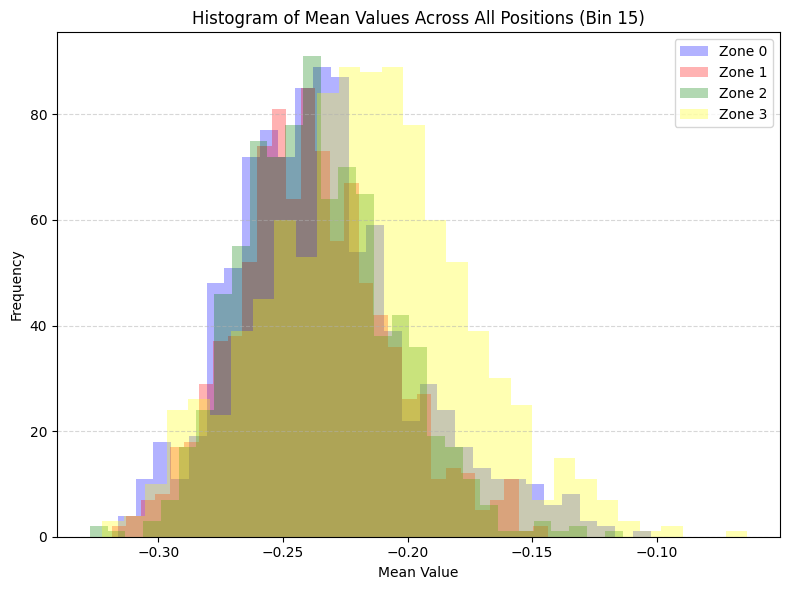

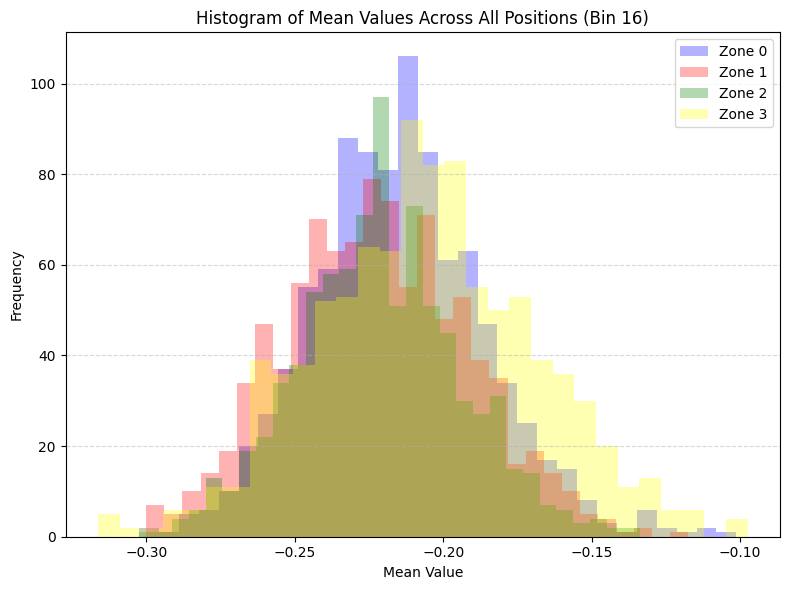

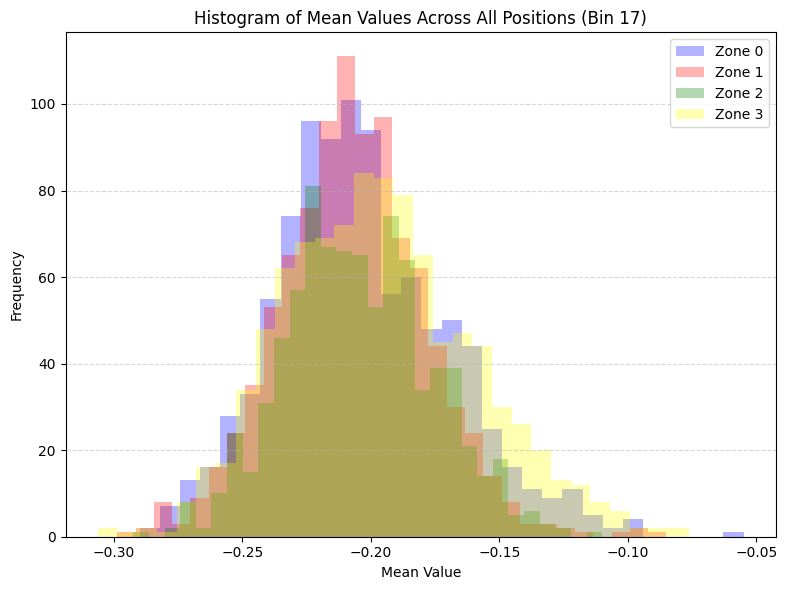

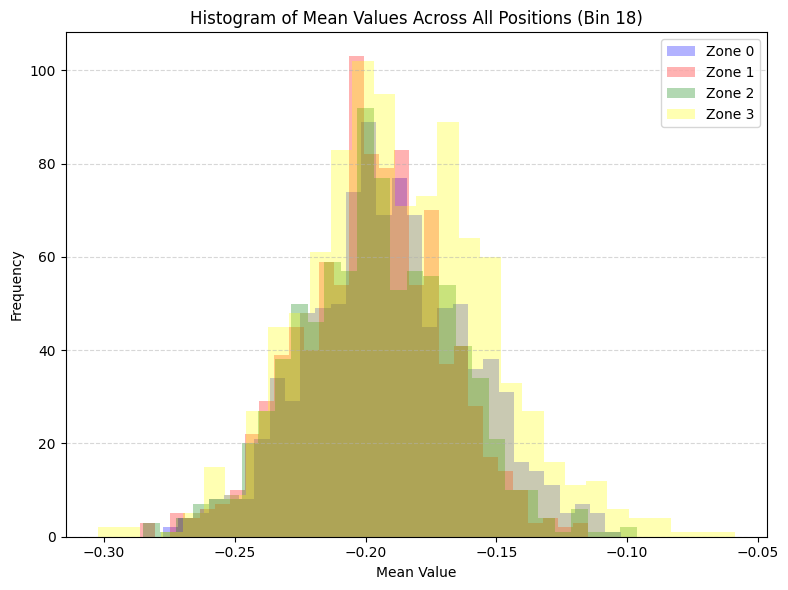

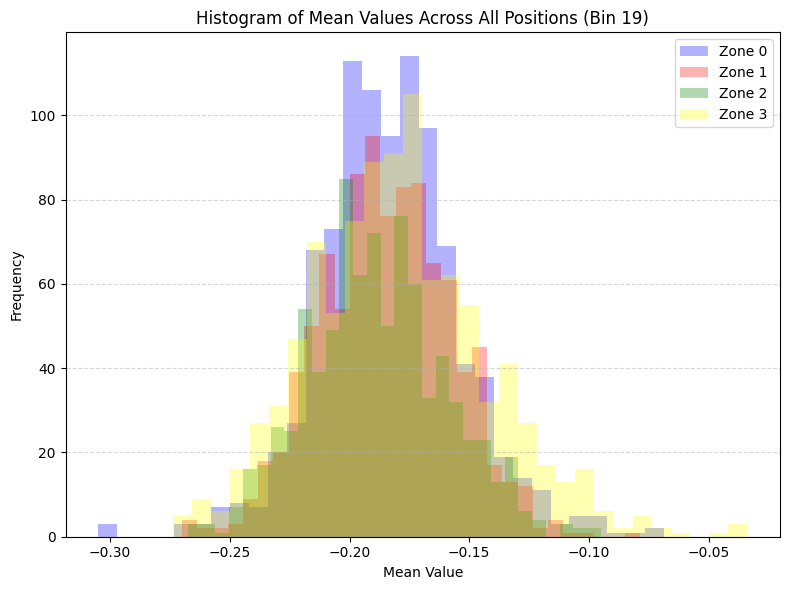

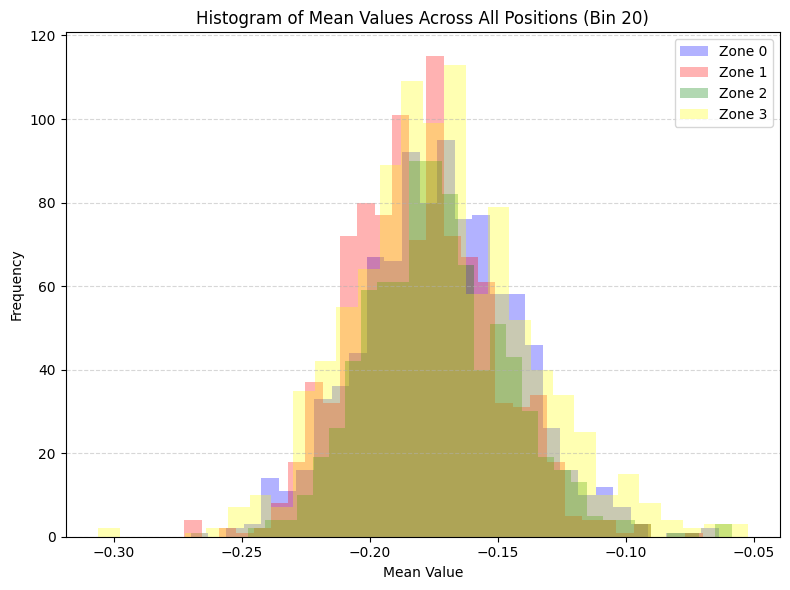

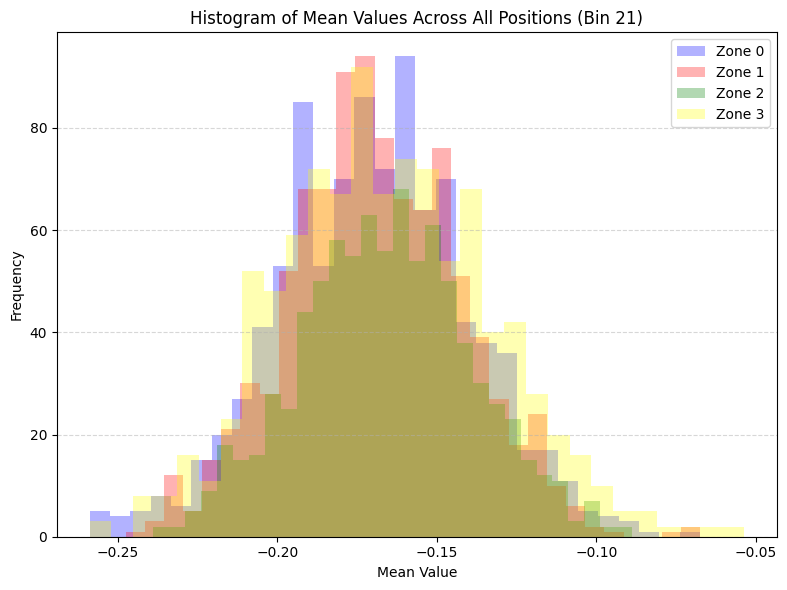

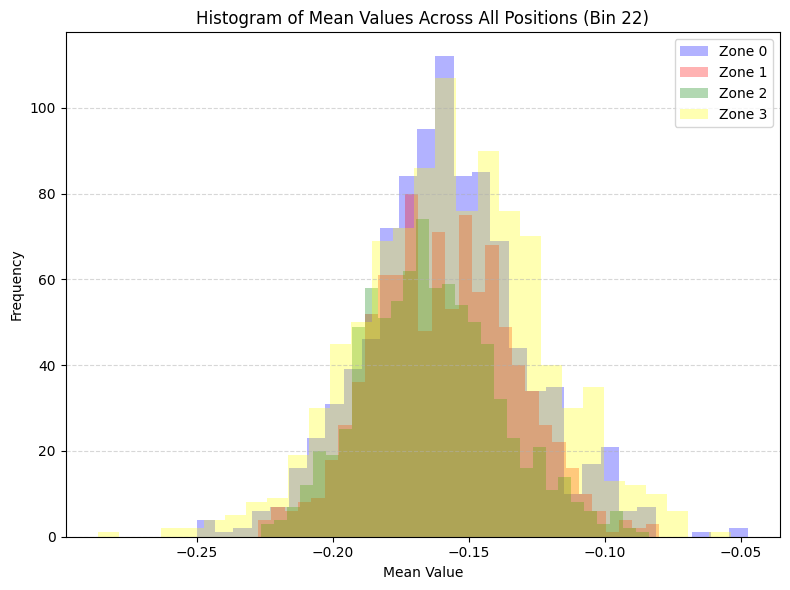

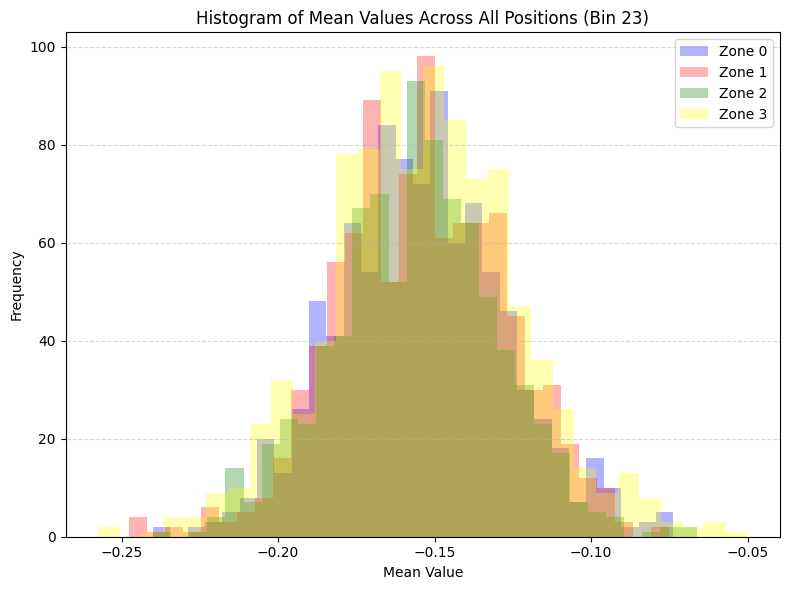

In [1232]:

for bin_num in range(all_hists.shape[1]):
    # Initialize arrays to store the mean values
    mean_data_0 = np.mean(all_hists[labels_mask_0][:, bin_num, :, :], axis=(1, 2))
    mean_data_1 = np.mean(all_hists[labels_mask_1][:, bin_num, :, :], axis=(1, 2))
    mean_data_2 = np.mean(all_hists[labels_mask_2][:, bin_num, :, :], axis=(1, 2))
    mean_data_3 = np.mean(all_hists[labels_mask_3][:, bin_num, :, :], axis=(1, 2))

    # Plot a single histogram of the mean values
    plt.figure(figsize=(8, 6))
    plt.hist(mean_data_0, bins=30, color='blue', alpha=0.3, label="Zone 0")
    plt.hist(mean_data_1, bins=30, color='red', alpha=0.3, label="Zone 1")
    plt.hist(mean_data_2, bins=30, color='green', alpha=0.3, label="Zone 2")
    plt.hist(mean_data_3, bins=30, color='yellow', alpha=0.3, label="Zone 3")

    # Add labels, legend, and title
    plt.xlabel("Mean Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Mean Values Across All Positions (Bin {bin_num})")
    plt.legend()

    # Show the plot
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## model setup

In [1117]:
start_bin = 4
end_bin = 16

In [1118]:
# class CounterCNN(nn.Module):
#     def __init__(self):
#         super(CounterCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
#         self.batchnorm1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
#         self.batchnorm2 = nn.BatchNorm2d(64)
#         # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(64 * 4 * 4, 128)
#         self.fc1_bn = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 3)  # Assuming 10 classes for the labels
#         self.relu = nn.LeakyReLU(negative_slope=0.01)
#         self.dropout = nn.Dropout(p=0.7)

#     def forward(self, x):
#         # print(f'x shape at start: {x.shape}')
#         x = self.relu(self.conv1(x))
#         # print(f'x shape after conv1: {x.shape}')
#         x = self.batchnorm1(x)
#         # x = self.pool(x)
#         # print(f'x shape after pool1: {x.shape}')
#         x = self.relu(self.conv2(x))
#         # print(f'x shape after conv2: {x.shape}')
#         x = self.batchnorm2(x)
#         # x = self.pool(x)
#         # print(f'x shape after pool2: {x.shape}')
#         x = torch.flatten(x, 1)
#         # print(f'x shape after flatten: {x.shape}')
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc1_bn(x)
#         x = self.fc2(x)
#         return x

In [1119]:
class CounterCNN(nn.Module):
    def __init__(self):
        super(CounterCNN, self).__init__()
        # self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
        # self.batchnorm1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        # self.batchnorm2 = nn.BatchNorm2d(64)

        out_channels = 4
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.batchnorm3d = nn.BatchNorm3d(out_channels)

        self.fc1 = nn.Linear(out_channels * (end_bin - start_bin) * height * width, 128)

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 3)  # Assuming 10 classes for the labels
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # # print(f'x shape at start: {x.shape}')
        # x = self.relu(self.conv1(x))
        # # print(f'x shape after conv1: {x.shape}')
        # x = self.batchnorm1(x)
        # # x = self.pool(x)
        # # print(f'x shape after pool1: {x.shape}')
        # x = self.relu(self.conv2(x))
        # # print(f'x shape after conv2: {x.shape}')
        # x = self.batchnorm2(x)

        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)

        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [1120]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [1121]:
model_save_path = 'models/display-box-16-rolling-means-location.mdl'
model = CounterCNN().to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_82662/2276183133.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

CounterCNN(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [1122]:
# load dataset
height = 4
width = 4
depth = 24

all_hists = []
labels = []
zero_hists = []

zone_to_label = {
    0: [0, 0, 0],
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1],
    4: [1, 1, 0],
    5: [1, 0, 1],
    6: [0, 1, 1],
    7: [1, 1, 1],
}

In [1123]:
for i in range(4):
    hists = np.load(f'datasets/display-box-6/histograms_{i}.npy')
    all_hists.append(hists)

    if i == 0:
        zero_hists.append(hists)

    labels += [zone_to_label[i]] * len(hists)

In [1124]:
zero_hists = np.concatenate(zero_hists, axis=0)
all_hists = np.concatenate(all_hists, axis=0)
labels = np.array(labels)

all_hists = all_hists.reshape(-1, height, width, depth)
# move depth to the front
all_hists = np.moveaxis(all_hists, -1, 1)

zero_hists = zero_hists.reshape(-1, height, width, depth)
zero_hists = np.moveaxis(zero_hists, -1, 1)

In [1125]:
# Compute the mean and standard deviation for each position (24, 4, 4) across all samples
mean = all_hists.mean(axis=0)  # Shape: (24, 4, 4)
std = all_hists.std(axis=0)    # Shape: (24, 4, 4)

# Compute the threshold for values being within 3 standard deviations
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Only consider the first n values along the depth axis (shape: n x 4 x 4)
n = 4
data_to_check = all_hists[:, :n, :, :]  # Shape: (4000, n, 4, 4)
lower_bound_check = lower_bound[:n, :, :]  # Shape: (n, 4, 4)
upper_bound_check = upper_bound[:n, :, :]  # Shape: (n, 4, 4)

# Identify samples where all values in the first 3 indices along the depth axis are within bounds
valid_mask = np.all((data_to_check >= lower_bound_check) & (data_to_check <= upper_bound_check), axis=(1, 2, 3))

# Apply the mask to filter the samples
filtered_all_hists = all_hists[valid_mask]
filtered_labels = labels[valid_mask]

# Check the shapes of the original and filtered arrays
print(f"Original shape: {all_hists.shape}")
print(f"Filtered shape: {filtered_all_hists.shape}")
all_hists = filtered_all_hists
labels = filtered_labels

Original shape: (4000, 24, 4, 4)
Filtered shape: (3883, 24, 4, 4)


In [1126]:
# crop first bounce bins (first bounce in first 2 bins)
# crop bins that are too far and noisy
all_hists = all_hists[:, start_bin:end_bin, :, :]
zero_hists = zero_hists[:, start_bin:end_bin, :, :]

In [1127]:
# # generate more data by adding gaussian noise

# all_hists = np.repeat(all_hists, 10, axis=0)
# labels = np.repeat(labels, 10, axis=0)

# # add noise
# # std = 3 is good for general training?
# all_hists += np.random.normal(0, 1, all_hists.shape)

In [1128]:
all_hists = torch.tensor(all_hists, dtype=torch.float32)
zero_hists = torch.tensor(zero_hists, dtype=torch.float32)

In [1129]:
# pick 20 random zero hists to act as the zero mean
num_samples_to_mean = 20

random_zero_mean = torch.empty((all_hists.shape[0], all_hists.shape[1], height, width))

for i in range(all_hists.shape[0]):
    indices = torch.randint(0, zero_hists.shape[0], (num_samples_to_mean,))
    random_zero_mean[i] = zero_hists[indices].mean(dim=0)

In [1130]:
all_hists_rel = all_hists - random_zero_mean

In [1131]:
print(f'shape of all_hists: {all_hists.shape}')
print(f'shape of labels: {labels.shape}')
print(f'shape of zero_mean: {all_hists_rel.shape}')
print(f'shape of all_hists_rel: {all_hists_rel.shape}')

shape of all_hists: torch.Size([3883, 12, 4, 4])
shape of labels: (3883, 3)
shape of zero_mean: torch.Size([3883, 12, 4, 4])
shape of all_hists_rel: torch.Size([3883, 12, 4, 4])


In [1132]:
# Convert numpy arrays to PyTorch tensors
# all_hists_tensor = torch.tensor(all_hists, dtype=torch.float32)
# all_hists_tensor = torch.tensor(all_hists_rel, dtype=torch.float32)
all_hists_tensor = all_hists_rel
# labels_tensor = torch.tensor(labels, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# all_hists_tensor = torch.sign(all_hists_tensor) * torch.log1p(torch.abs(all_hists_tensor))


# epsilon = 0.1  # Smoothing factor
# labels_tensor = (1 - epsilon) * labels_tensor + epsilon * 0.5  # Smooth towards uniform distribution

# Create a TensorDataset
dataset = TensorDataset(all_hists_tensor, labels_tensor)

# Define the sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [1133]:
model.type

<bound method Module.type of CounterCNN(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)>

In [1134]:
all_hists_tensor.shape

torch.Size([3883, 12, 4, 4])

In [1135]:
shap_input = all_hists_tensor.to(device)

In [1136]:
# Create SHAP explainer
explainer = shap.GradientExplainer(model, shap_input)

# Select a sample to explain
# samples_to_explain = shap_input[:10]  # First 10 samples
# get random 100 samples
indices = torch.randint(0, shap_input.shape[0], (100,))
samples_to_explain = shap_input[indices]

# Compute SHAP values
shap_values = explainer.shap_values(samples_to_explain)

In [1137]:
samples_to_explain.shape

torch.Size([100, 12, 4, 4])

In [1138]:
print(f"SHAP values shape: {shap_values.shape}")

SHAP values shape: (100, 12, 4, 4, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24361496391063603..0.25446206223365825].


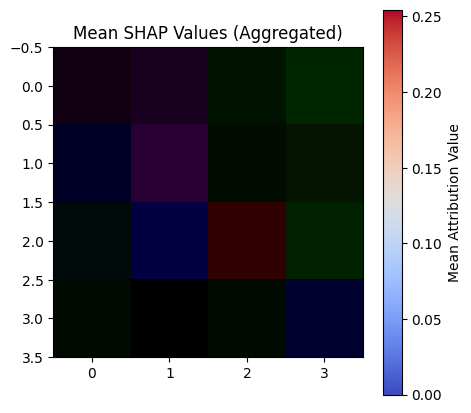

In [1139]:
# Aggregate SHAP values over all samples
mean_shap_values = shap_values.mean(axis=0)

# Visualize mean SHAP values
plt.figure(figsize=(5, 5))
plt.title("Mean SHAP Values (Aggregated)")
plt.imshow(mean_shap_values[0, :, :], cmap="coolwarm", interpolation="nearest")  # First channel
plt.colorbar(label="Mean Attribution Value")
plt.show()

In [1140]:
mean_shap_values.shape

(12, 4, 4, 3)

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_82662/916481221.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


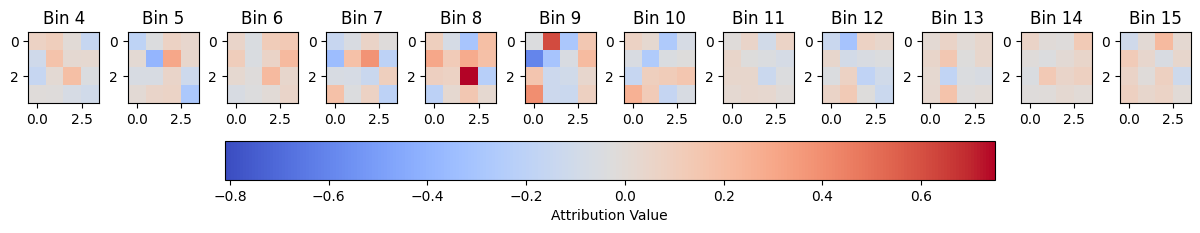

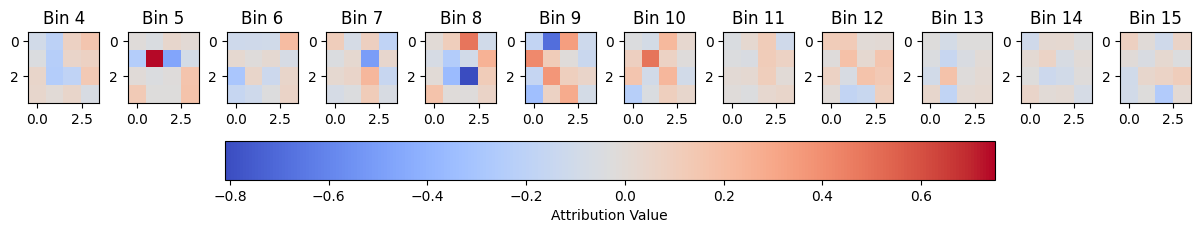

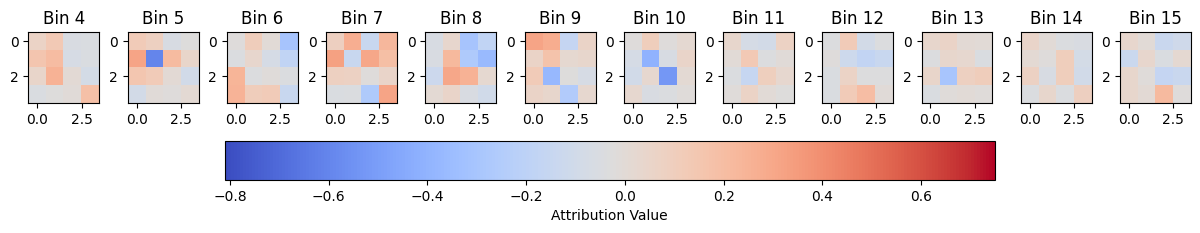

In [1141]:
# Calculate global min and max across all channels
min_val = mean_shap_values.min()
max_val = mean_shap_values.max()

for i in range(3):
    shap_values_sample = mean_shap_values[..., i]

    # Plot each channel with a shared colorbar
    fig, axes = plt.subplots(1, end_bin - start_bin, figsize=(15, 5), gridspec_kw={'wspace': 0.4})
    for channel in range(end_bin - start_bin):
        ax = axes[channel]
        ax.set_title(f"Bin {channel + start_bin}")
        im = ax.imshow(shap_values_sample[channel], cmap="coolwarm", vmin=min_val, vmax=max_val, interpolation="nearest")
        # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Attribution Value")
    plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.1, pad=0.1, label="Attribution Value")
    plt.tight_layout()
    plt.show()

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_82662/3071738218.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


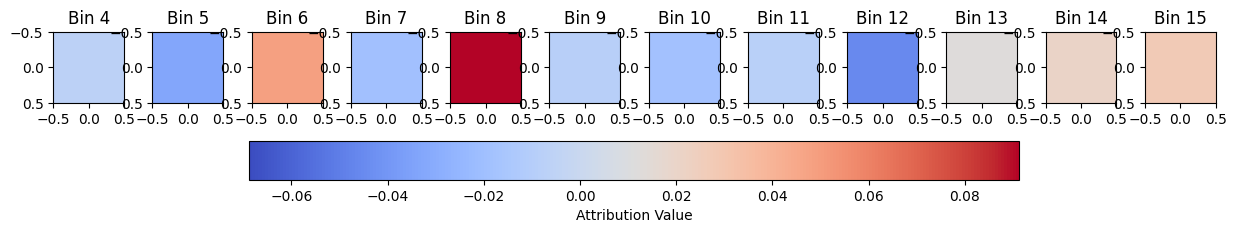

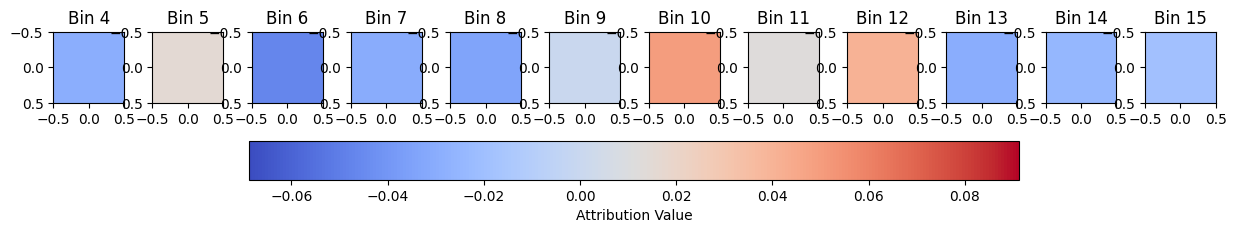

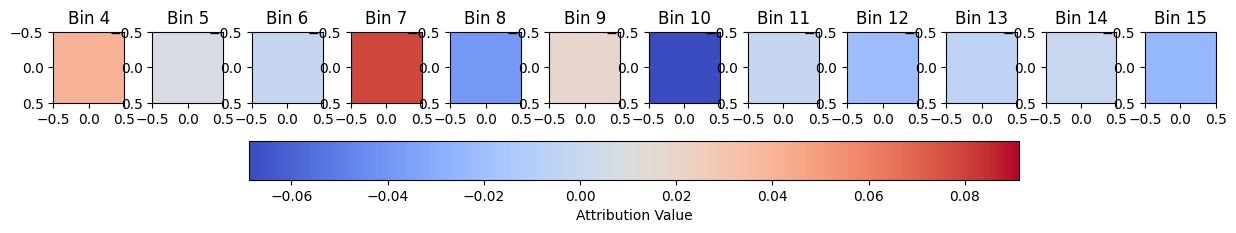

In [1142]:
aggregate_shap_means = mean_shap_values.mean(axis=(1, 2), keepdims=True)

# Calculate global min and max across all channels
min_val = aggregate_shap_means.min()
max_val = aggregate_shap_means.max()

for i in range(3):
    shap_values_sample = aggregate_shap_means[..., i].mean(axis=(1, 2), keepdims=True)

    # Plot each channel with a shared colorbar
    fig, axes = plt.subplots(1, end_bin - start_bin, figsize=(15, 5), gridspec_kw={'wspace': 0.4})
    for channel in range(end_bin - start_bin):
        ax = axes[channel]
        ax.set_title(f"Bin {channel + start_bin}")
        im = ax.imshow(shap_values_sample[channel], cmap="coolwarm", vmin=min_val, vmax=max_val, interpolation="nearest")
        # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Attribution Value")
    plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.1, pad=0.1, label="Attribution Value")
    plt.tight_layout()
    plt.show()

In [29]:
# pick 20 random zero hists to act as the zero mean
num_samples_to_mean = 20

random_zero_mean = torch.empty((all_hists.shape[0], all_hists.shape[1], height, width))

for i in range(all_hists.shape[0]):
    indices = torch.randint(0, zero_hists.shape[0], (num_samples_to_mean,))
    random_zero_mean[i] = zero_hists[indices].mean(dim=0)

In [30]:
# normalize to 0-1 values
all_hist_mins = all_hists.amin(dim=(1, 2, 3), keepdim=True)
all_hist_maxs = all_hists.amax(dim=(1, 2, 3), keepdim=True)
all_hist_ranges = all_hist_maxs - all_hist_mins
all_hist_ranges[all_hist_ranges == 0] = 1
all_hists = (all_hists - all_hist_mins) / all_hist_ranges

# normalize to 0-1 values
random_zero_mean_mins = random_zero_mean.amin(dim=(1, 2, 3), keepdim=True)
random_zero_mean_maxs = random_zero_mean.amax(dim=(1, 2, 3), keepdim=True)
random_zero_mean_ranges = random_zero_mean_maxs - random_zero_mean_mins
random_zero_mean_ranges[random_zero_mean_ranges == 0] = 1
random_zero_mean = (random_zero_mean - random_zero_mean_mins) / random_zero_mean


In [31]:
all_hists_rel = all_hists - random_zero_mean

In [32]:
# mean all pixels
# all_hists_rel = all_hists_rel.mean(dim=(2, 3), keepdim=True)

In [33]:
# zero_mean = np.mean(zero_hists, axis=0)

# # lower bound at 0
# # all_hists = np.maximum(all_hists, 0)
# # zero_mean = np.maximum(zero_mean, 0)
# all_hists_rel = all_hists - zero_mean

In [34]:
# value-based normalization
# data is of shape (n x depth x height x width): (n, 24, 4, 4)
# apply 2d gaussian over heigh x width

# kernel = [0.5, 1, 0.5]

# blurred = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=0.5, mode='constant'), 2, all_hists_rel)
# blurred = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=0.5, mode='constant'), 3, blurred)

# # 1d gaussian over depth
blurred = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=0.5, mode='constant'), 1, blurred)

all_hists_rel = blurred

# sharpened = all_hists_rel - blurred
# all_hists_rel = sharpened

NameError: name 'blurred' is not defined

In [ ]:
# normalize values

In [ ]:
# plot histogram of values of all_hists on log scale in matplotlib
temp = all_hists_rel[labels==2].flatten()
fig, ax = plt.subplots()
# ax.hist(temp[(temp > 10) | (temp < -10)], bins=50)
ax.hist(temp, bins=50)
plt.show()


IndexError: boolean index did not match indexed array along dimension 1; dimension is 24 but corresponding boolean dimension is 3

In [ ]:
print(f"nonnegative count: {np.sum(zero_mean >= 0)}")
print(f"negative count: {np.sum(zero_mean < 0)}")
print(f"total count: {zero_mean.size}")

nonnegative count: 113
negative count: 271
total count: 384


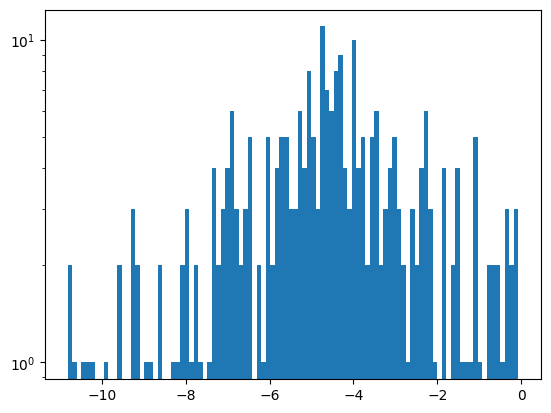

In [ ]:
# plot histogram of all negative samples in all_hists

fig, ax = plt.subplots()
ax.hist(zero_mean[zero_mean < 0].flatten(), bins=100, log=True)
plt.show()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 24 but corresponding boolean dimension is 3

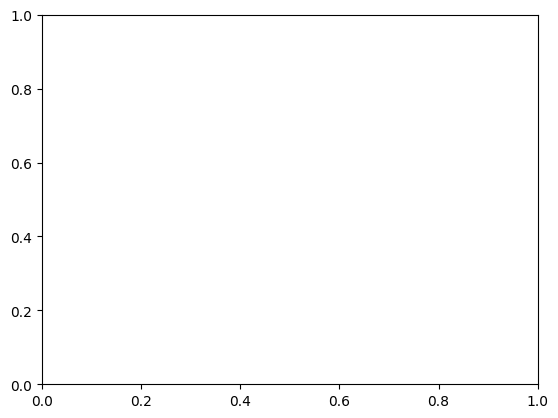

In [ ]:
fig, ax = plt.subplots()
ax.hist(all_hists_rel[labels == 0].flatten(), bins=100, log=True)
plt.show()

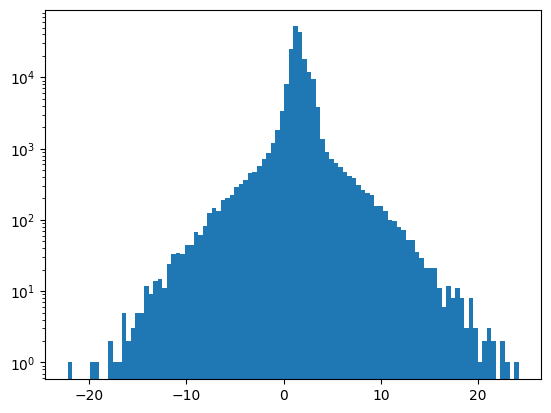

In [ ]:
fig, ax = plt.subplots()
ax.hist(all_hists_rel[labels == 9].flatten(), bins=100, log=True)
plt.show()

In [ ]:
print(f'shape of all_hists: {all_hists.shape}')
print(f'shape of labels: {labels.shape}')
print(f'shape of zero_mean: {all_hists_rel.shape}')
print(f'shape of all_hists_rel: {all_hists_rel.shape}')

shape of all_hists: torch.Size([40000, 22, 4, 4])
shape of labels: (40000, 3)
shape of zero_mean: torch.Size([40000, 22, 4, 4])
shape of all_hists_rel: torch.Size([40000, 22, 4, 4])


In [ ]:
# Convert numpy arrays to PyTorch tensors
# all_hists_tensor = torch.tensor(all_hists, dtype=torch.float32)
# all_hists_tensor = torch.tensor(all_hists_rel, dtype=torch.float32)
all_hists_tensor = all_hists_rel
# labels_tensor = torch.tensor(labels, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# all_hists_tensor = torch.sign(all_hists_tensor) * torch.log1p(torch.abs(all_hists_tensor))


# epsilon = 0.1  # Smoothing factor
# labels_tensor = (1 - epsilon) * labels_tensor + epsilon * 0.5  # Smooth towards uniform distribution

# Create a TensorDataset
dataset = TensorDataset(all_hists_tensor, labels_tensor)

# Define the sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch_x, batch_y in train_loader:
    print(f'batch_x shape: {batch_x.shape}')
    print(f'batch_y shape: {batch_y.shape}')
    break

batch_x shape: torch.Size([32, 22, 4, 4])
batch_y shape: torch.Size([32, 3])


In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)  # Assuming 10 classes for the labels
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(f'x shape at start: {x.shape}')
        x = self.relu(self.conv1(x))
        # print(f'x shape after conv1: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool1: {x.shape}')
        x = self.relu(self.conv2(x))
        # print(f'x shape after conv2: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
class BigCNN(nn.Module):
    def __init__(self):
        super(BigCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for the labels
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(f'x shape at start: {x.shape}')
        x = self.relu(self.conv1(x))
        # print(f'x shape after conv1: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool1: {x.shape}')
        x = self.relu(self.conv2(x))
        # print(f'x shape after conv2: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        x = nn.Dropout(0.5)(x)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
# model = BigCNN().to(device)
# print(model)

BigCNN(
  (conv1): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
class CounterCNN(nn.Module):
    def __init__(self):
        super(CounterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=(depth - 2), out_channels=32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 3)  # Assuming 10 classes for the labels
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # print(f'x shape at start: {x.shape}')
        x = self.relu(self.conv1(x))
        # print(f'x shape after conv1: {x.shape}')
        x = self.batchnorm1(x)
        # x = self.pool(x)
        # print(f'x shape after pool1: {x.shape}')
        x = self.relu(self.conv2(x))
        # print(f'x shape after conv2: {x.shape}')
        x = self.batchnorm2(x)
        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CounterCNN().to(device)
print(model)

CounterCNN(
  (conv1): Conv2d(22, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [ ]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(initialize_weights)

CounterCNN(
  (conv1): Conv2d(22, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [ ]:
# for sipmle cnn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, counter=False, clipping=False, debug=False):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # print(f'X shape: {X.shape}, y shape: {y.shape}')
        # Compute prediction error
        pred = model(X)
        # if counter:
            # y = y.unsqueeze(1)
        # print(f'pred shape: {pred.shape}, y shape: {y.shape}')
        loss = loss_fn(pred, y)
        # print(f'loss: {loss.item()}')
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        if clipping:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed
        
        if debug:
            # Inspect gradients for each layer
            for name, param in model.named_parameters():
                if param.grad is not None:  # Only check if gradient is computed
                    print(f"Layer: {name} | Gradient mean: {param.grad.abs().mean().item()} | Gradient max: {param.grad.abs().max().item()}")
                else:
                    print(f"Layer: {name} has no gradient.")

        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [ ]:
def test_counter(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y = y.unsqueeze_(1)
            # print(X.shape)
            # print(y.shape)
            test_loss += loss_fn(pred, y).item()
            final_pred = torch.round(torch.clamp(pred, min=0, max=1))
            
            # print(final_pred.shape)
            # print("true")
            # print(y)
            # print("pred")
            # print(final_pred)
            # print("diff")
            # print(final_pred - y)
            exact_match = torch.all(final_pred == torch.round(y), dim=1)
            correct += torch.sum(exact_match).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [ ]:
def train_early_stopping(train_loader, val_loader, model, loss_fn, optimizer, 
    epochs=50, early_stopping=True, patience=5, threshold=0.15, counter=False, clipping=False, debug=False):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, counter=counter, clipping=clipping, debug=debug)
        if counter:
            val_loss, correct = test_counter(val_loader, model, loss_fn)
        else:
            val_loss, correct = test(val_loader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                patience_counter = 0
            else:
                if val_loss / best_val_loss > 1 + threshold:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {t+1}")
                        break
        # print(f'patience_counter: {patience_counter}')
    return best_model, train_losses, val_losses

In [ ]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(val_loader, model, loss_fn)
    # test_counter(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.801082  [   32/ 2450]


RuntimeError: The size of tensor a (32) must match the size of tensor b (3) at non-singleton dimension 1

Epoch 1
-------------------------------
loss: 0.855346  [   32/20000]
loss: 0.643335  [ 3232/20000]
loss: 0.533626  [ 6432/20000]
loss: 0.542203  [ 9632/20000]
loss: 0.595033  [12832/20000]
loss: 0.549997  [16032/20000]
loss: 0.569985  [19232/20000]
Test Error: 
 Accuracy: 25.0%, Avg loss: 0.561438 

Epoch 2
-------------------------------
loss: 0.543111  [   32/20000]
loss: 0.579272  [ 3232/20000]
loss: 0.567110  [ 6432/20000]
loss: 0.576267  [ 9632/20000]
loss: 0.501127  [12832/20000]
loss: 0.539399  [16032/20000]
loss: 0.556141  [19232/20000]
Test Error: 
 Accuracy: 25.0%, Avg loss: 0.556523 

Epoch 3
-------------------------------
loss: 0.502816  [   32/20000]
loss: 0.491290  [ 3232/20000]
loss: 0.500271  [ 6432/20000]
loss: 0.540242  [ 9632/20000]
loss: 0.505136  [12832/20000]
loss: 0.476902  [16032/20000]
loss: 0.518066  [19232/20000]
Test Error: 
 Accuracy: 25.0%, Avg loss: 0.553692 

Epoch 4
-------------------------------
loss: 0.581470  [   32/20000]
loss: 0.615769  [ 3232/2

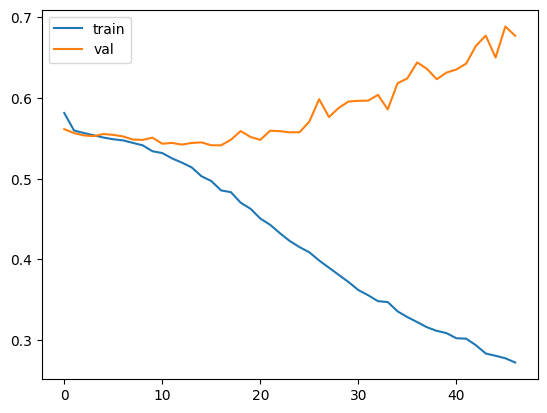

In [ ]:
best_model, train_losses, val_losses = train_early_stopping(
    train_loader, val_loader, model, loss_fn, optimizer, epochs=500, early_stopping=True,
    threshold=0.2,
    counter=True, clipping=True)

# plot training and validation losses
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


model = best_model

In [ ]:
model_save_path = 'models/display-box-4.pth'

In [ ]:
torch.save(model.state_dict(), model_save_path)

In [ ]:
model = CounterCNN().to(device)
model.load_state_dict(torch.load(model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_73286/2522857457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

<All keys matched successfully>

In [ ]:
# Out of sample test
model.eval()
# test(test_loader, model, loss_fn)
test_counter(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 33.6%, Avg loss: 0.662207 



(0.6622068341166828, 0.3364)

In [ ]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data)

    # Get the predicted class
    predicted_class = output.argmax(dim=1).item()

    # Print the predicted class and the actual label
    print(f'Predicted class: {predicted_class}, Actual label: {example_label}')

Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 0, Actual label: tensor([0., 0., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 0, Actual label: tensor([0., 0., 0.])
Predicted class: 0, Actual label: tensor([0., 0., 0.])
Predicted class: 0, Actual label: tensor([0., 0., 1.])
Predicted class: 0, Actual label: tensor([0., 1., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 0, Actual label: tensor([1., 0., 0.])
Predicted class: 1, Actual label: tensor([0., 0., 0.])
Predicted class: 0, Actual label: tensor([0., 0., 1.])
Predicted class: 2, Actual label: tensor([0., 0., 1.])
Predicted class: 1, Actual label: tensor([0., 0., 1.])
Predicted class: 1, Actual label: tensor([0., 0., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 0, Actual label: tensor([0., 0., 0.])
Predicted class: 1, Actual label: tensor([1., 0., 0.])
Predicted 

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        output = model(X)
        # predicted_classes = output.argmax(dim=1)
        # predictions.extend(predicted_classes.cpu().numpy())
        predicted_zones = torch.round(torch.clamp(output, min=0, max=1))
        predictions.extend(predicted_zones.cpu().numpy())

# Convert predictions to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in test_dataset])

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
# FULL DATASET
# Create a DataLoader for the entire dataset
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize a list to store the predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in full_loader:
        X = X.to(device)
        output = model(X)
        predicted_classes = output.argmax(dim=1)
        predictions.extend(predicted_classes.cpu().numpy())

# Convert outputs to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in dataset])

[1 0 1 ... 2 2 2]


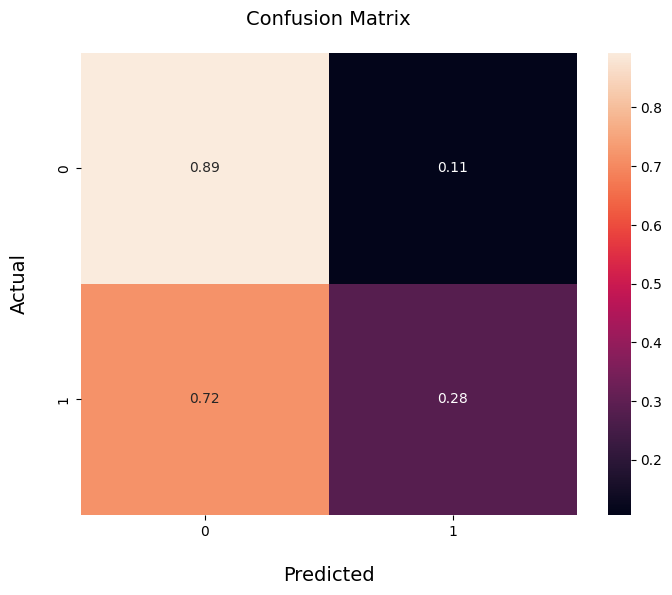

In [ ]:
y_test = np.array([y[0] for _, y in test_dataset]).astype(int)
y_preds = np.array([p[0] for p in predictions]).astype(int)
conf_matrix = confusion_matrix(y_test, y_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# tick_labels = [0, 1, 2, 3, 4, 5, 6]
# tick_labels = [0, 1, 2]
tick_labels = [0, 1]
ax.xaxis.set_ticklabels(tick_labels)
 
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(tick_labels)
 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()

In [ ]:
y_test

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,

In [ ]:
y_test

array([[0, 0, 1],
       [0, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [ ]:
y_preds

array([[0, 0, 1],
       [0, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [ ]:
category_y_preds

array([1, 0, 1, ..., 0, 4, 2])

[0.7415 0.7472 0.7581]


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (8).

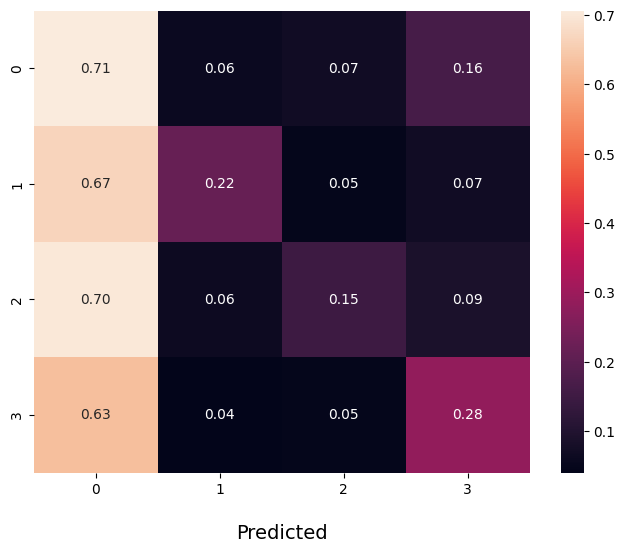

In [ ]:
y_test = np.array([y for _, y in test_dataset]).astype(int)
y_preds = np.array([p for p in predictions]).astype(int)

# plot accuracy of each zone
correct = (y_test == y_preds)
zone_correct = np.sum(correct, axis=0)
zone_total = np.sum(y_test == y_test, axis=0)

zone_accuracy = zone_correct / zone_total
print(zone_accuracy)

category_y_test = y_test.dot(2**np.arange(2, -1, -1))
category_y_preds = y_preds.dot(2**np.arange(2, -1, -1))

conf_matrix = confusion_matrix(category_y_test, category_y_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# tick_labels = ["000", "001", "010", "011", "100", "101", "110"]
tick_labels = ["000", "001", "010", "011", "100", "101", "110", "111"]
# tick_labels = ["000", "001", "010", "100"]
ax.xaxis.set_ticklabels(tick_labels)
 
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(tick_labels)
 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()